# Stock Price Prediction Using Regression Models

## Problem Statement

Stock price prediction is a fundamental regression problem in financial forecasting. The goal is to predict the **next day's closing price** based on historical price movements and technical indicators. This is a challenging task due to:

- **High volatility**: Stock prices are influenced by numerous unpredictable factors
- **Non-stationarity**: Statistical properties change over time
- **Market noise**: Random fluctuations can obscure underlying patterns
- **External factors**: News, macroeconomic events, and market sentiment

## Approach Overview

This notebook implements and compares **6 different regression models**:

1. **Linear Regression**: Simple, interpretable baseline with assumption of linear relationships
2. **Decision Tree Regressor**: Non-parametric model that captures non-linear patterns
3. **K-Nearest Neighbors (KNN)**: Instance-based learning using similarity measures
4. **Gradient Boosting**: Powerful ensemble method combining weak learners
5. **Stacking Regressor**: Meta-learning approach combining multiple base models
6. **Neural Network (MLP)**: Deep learning approach for complex pattern recognition

## Methodology

- **Stocks analyzed**: AAPL, MSFT, NVDA, TSLA, AMZN
- **Time period**: Last 5 years
- **Features**: Technical indicators (moving averages, RSI, MACD, Bollinger Bands, etc.)
- **Evaluation metrics**: RMSE, MAE, R²
- **Validation approach**: Chronological train-test split (80/20) to prevent data leakage

## 1. Import Required Libraries

In [38]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Data acquisition
import yfinance as yf
from datetime import datetime, timedelta

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Machine Learning - Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

# Machine Learning - Models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, StackingRegressor, RandomForestRegressor
from sklearn.neural_network import MLPRegressor

# Machine Learning - Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Set random seed for reproducibility
np.random.seed(35)

print("All libraries imported successfully!")
print(f"\nNotebook created on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

All libraries imported successfully!

Notebook created on: 2025-11-07 06:05:19


## 2. Data Collection

In this section, we download historical stock data for 5 major technology companies:
- **AAPL**: Apple Inc.
- **MSFT**: Microsoft Corporation
- **NVDA**: NVIDIA Corporation
- **TSLA**: Tesla, Inc.
- **AMZN**: Amazon.com, Inc.

We use the `yfinance` library to fetch the last **5 years** of daily trading data, including:
- Open, High, Low, Close prices
- Adjusted Close price
- Trading Volume

In [2]:
# Define the stock tickers we want to analyze
tickers = ['AAPL', 'MSFT', 'NVDA', 'TSLA', 'AMZN']

# Calculate date range: last 5 years from today
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print(f"Downloading stock data from {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")
print("=" * 80)

# Dictionary to store dataframes for each stock
stock_data = {}

# Download data for each stock with error handling
for ticker in tickers:
    try:
        print(f"\nDownloading {ticker}...", end=" ")
        # Download historical data using yfinance
        df = yf.download(ticker, start=start_date, end=end_date, progress=False)

        if df.empty:
            print(f"❌ Failed: No data returned")
            continue

        # Store the dataframe
        stock_data[ticker] = df
        print(f"✓ Success: {len(df)} trading days retrieved")

    except Exception as e:
        print(f"❌ Error: {str(e)}")
        continue

print("\n" + "=" * 80)
print(f"Successfully downloaded data for {len(stock_data)} stocks: {list(stock_data.keys())}")

# Display a quick preview of one stock
print(f"\nPreview of {tickers[0]} data (first 5 rows):")
print(stock_data[tickers[0]].head())







Successfully downloaded data for 5 stocks: ['AAPL', 'MSFT', 'NVDA', 'TSLA', 'AMZN']

Preview of AAPL data (first 5 rows):
Price            Close        High         Low        Open     Volume
Ticker            AAPL        AAPL        AAPL        AAPL       AAPL
Date                                                                 
2020-11-09  113.341728  118.866551  113.078645  117.414703  154515300
2020-11-10  113.000687  114.579203  111.207794  112.591442  138023400
2020-11-11  116.430557  116.566972  113.458654  114.189451  112295000
2020-11-12  116.157745  117.443948  115.534133  116.557251  103162300
2020-11-13  116.206474  116.605973  114.852064  116.381866   81581900


## 3. Data Exploration & Analysis

Before building predictive models, we need to understand our data thoroughly. This section examines:
- Data structure and quality (missing values, data types)
- Statistical properties of each stock
- Time series patterns and trends
- Relationships between different stocks

### 3.1 Data Structure and Quality Assessment

In [3]:
# Examine data structure for each stockprint("DATA STRUCTURE AND QUALITY CHECK")
print("=" * 80)
for ticker in tickers:
    if ticker not in stock_data:
        continue
        df = stock_data[ticker]
        print(f"\n{'─' * 80}")
        print(f"Stock: {ticker}")
        print(f"{'─' * 80}")        # Shape information
print(f"\n1. SHAPE: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"   Date Range: {df.index[0].strftime('%Y-%m-%d')} to {df.index[-1].strftime('%Y-%m-%d')}")        # Data types
print(f"\n2. DATA TYPES:")
print(df.dtypes)        # Missing values
missing = df.isnull().sum()
print(f"\n3. MISSING VALUES:")
if missing.sum() == 0:
    print("   ✓ No missing values detected")
else:
    print(missing[missing > 0])
    # Statistical summary for Close price
    print(f"\n4. STATISTICAL SUMMARY (Close Price):")
    print(f"   Mean:     ${float(df['Close'].mean()):.2f}")
    print(f"   Std Dev:  ${float(df['Close'].std()):.2f}")
    print(f"   Min:      ${df['Close'].min():.2f}")
    print(f"   Max:      ${df['Close'].max():.2f}")
    print(f"   Median:   ${df['Close'].median():.2f}")
    print("\n" + "=" * 80)
    print("✓ Data quality check complete!")


1. SHAPE: 1254 rows × 5 columns
   Date Range: 2020-11-09 to 2025-11-06

2. DATA TYPES:
Price   Ticker
Close   AMZN      float64
High    AMZN      float64
Low     AMZN      float64
Open    AMZN      float64
Volume  AMZN        int64
dtype: object

3. MISSING VALUES:
   ✓ No missing values detected


### 3.2 Time Series Visualization of Closing Prices

Visualizing historical closing prices helps us understand:
- Long-term trends (upward, downward, or sideways)
- Volatility patterns
- Major price movements and events
- Comparative performance across stocks

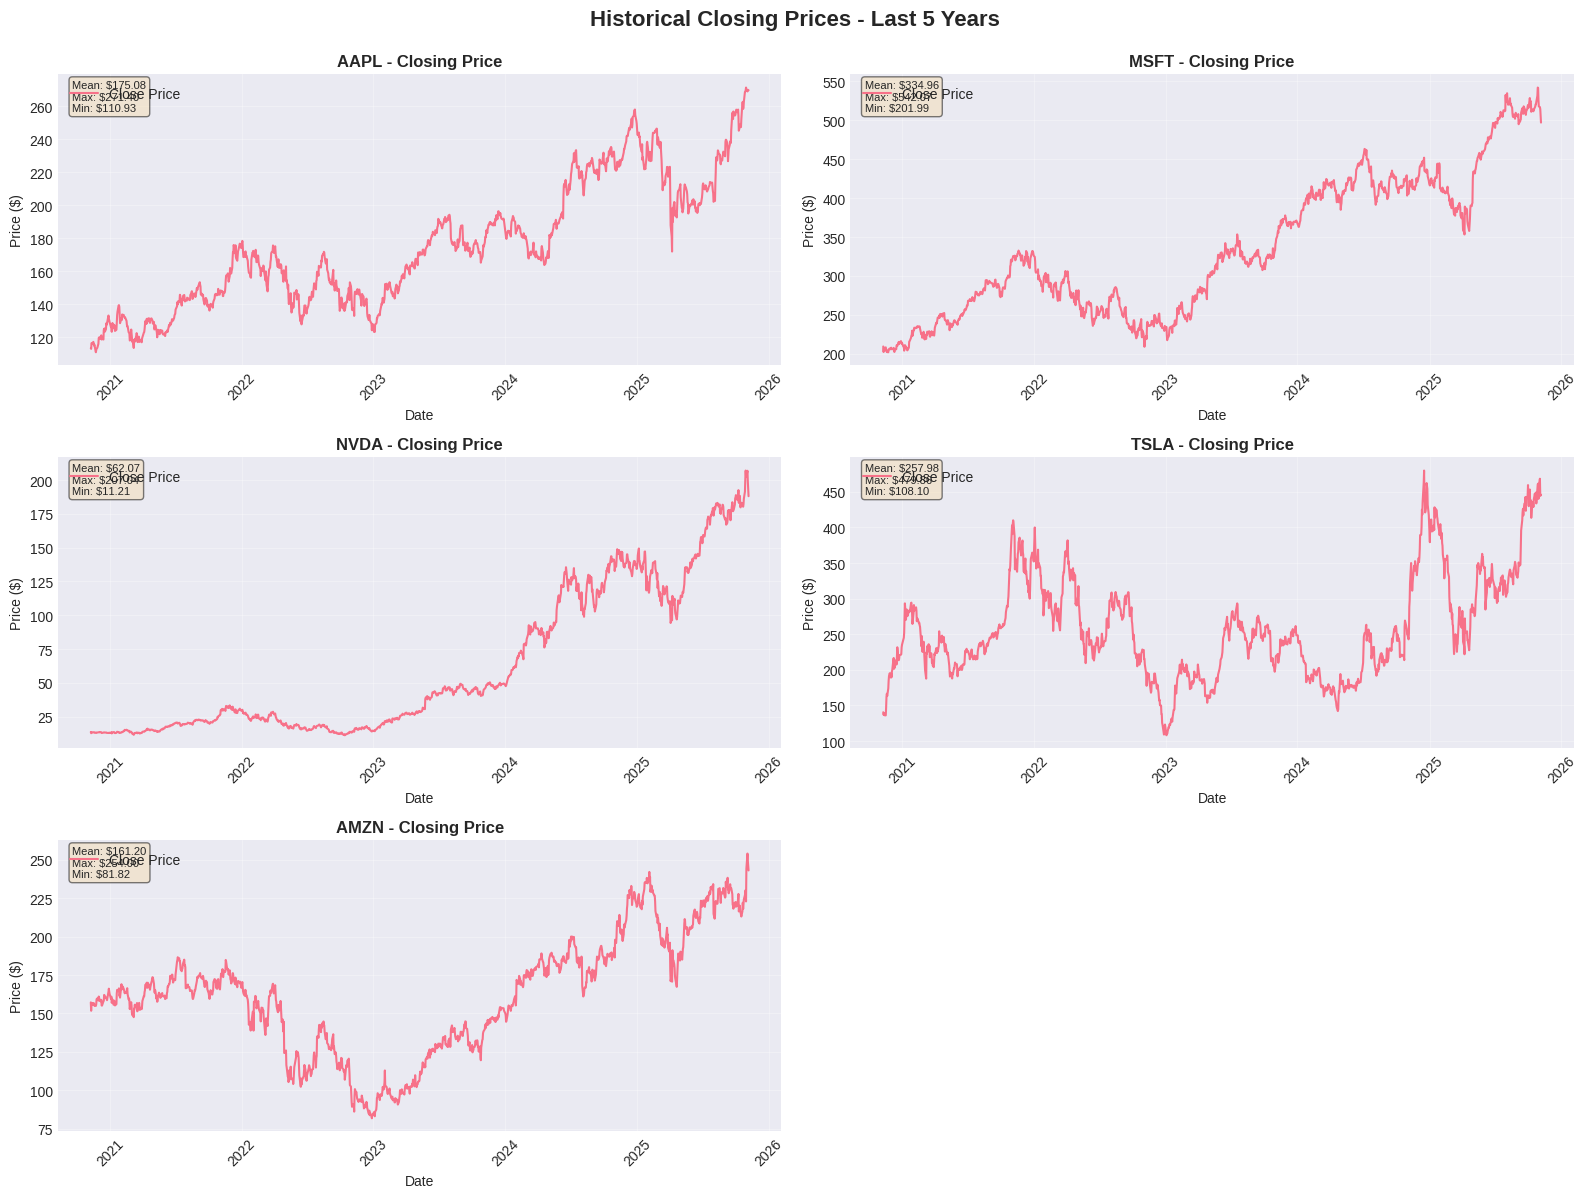


✓ Time series plots generated successfully!


In [4]:
# Create subplots for each stock's closing price time series
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
fig.suptitle('Historical Closing Prices - Last 5 Years', fontsize=16, fontweight='bold', y=0.995)
# Flatten axes for easier iteration
axes = axes.flatten()
# Plot each stock
for idx, ticker in enumerate(tickers):
  if ticker not in stock_data:
      continue

  ax = axes[idx]
  df = stock_data[ticker]

  # Plot closing price
  ax.plot(df.index, df['Close'], linewidth=1.5, label='Close Price')

  # Add title and labels
  ax.set_title(f'{ticker} - Closing Price', fontsize=12,fontweight='bold')
  ax.set_xlabel('Date', fontsize=10)
  ax.set_ylabel('Price ($)', fontsize=10)
  ax.grid(True, alpha=0.3)
  ax.legend(loc='upper left')

  # Rotate x-axis labels for better readability
  ax.tick_params(axis='x', rotation=45)

  # Add summary statistics as text
  mean_price = float(df['Close'].mean())
  max_price = float(df['Close'].max())
  min_price = float(df['Close'].min())

  stats_text = f'Mean: ${mean_price:.2f}\nMax: ${max_price:.2f}\nMin: ${min_price:.2f}'
  ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, verticalalignment='top', bbox=dict(boxstyle='round',facecolor='wheat', alpha=0.5),fontsize=8)

# Hide the extra subplot (OUTSIDE the loop!)
axes[-1].axis('off')
plt.tight_layout()
plt.show()
print("\n✓ Time series plots generated successfully!")

### 3.3 Volume Trends Analysis

Trading volume is an important indicator of:
- **Market interest**: Higher volume indicates more activity
- **Liquidity**: Easier to buy/sell without impacting price
- **Price movement validation**: Volume confirms price trends

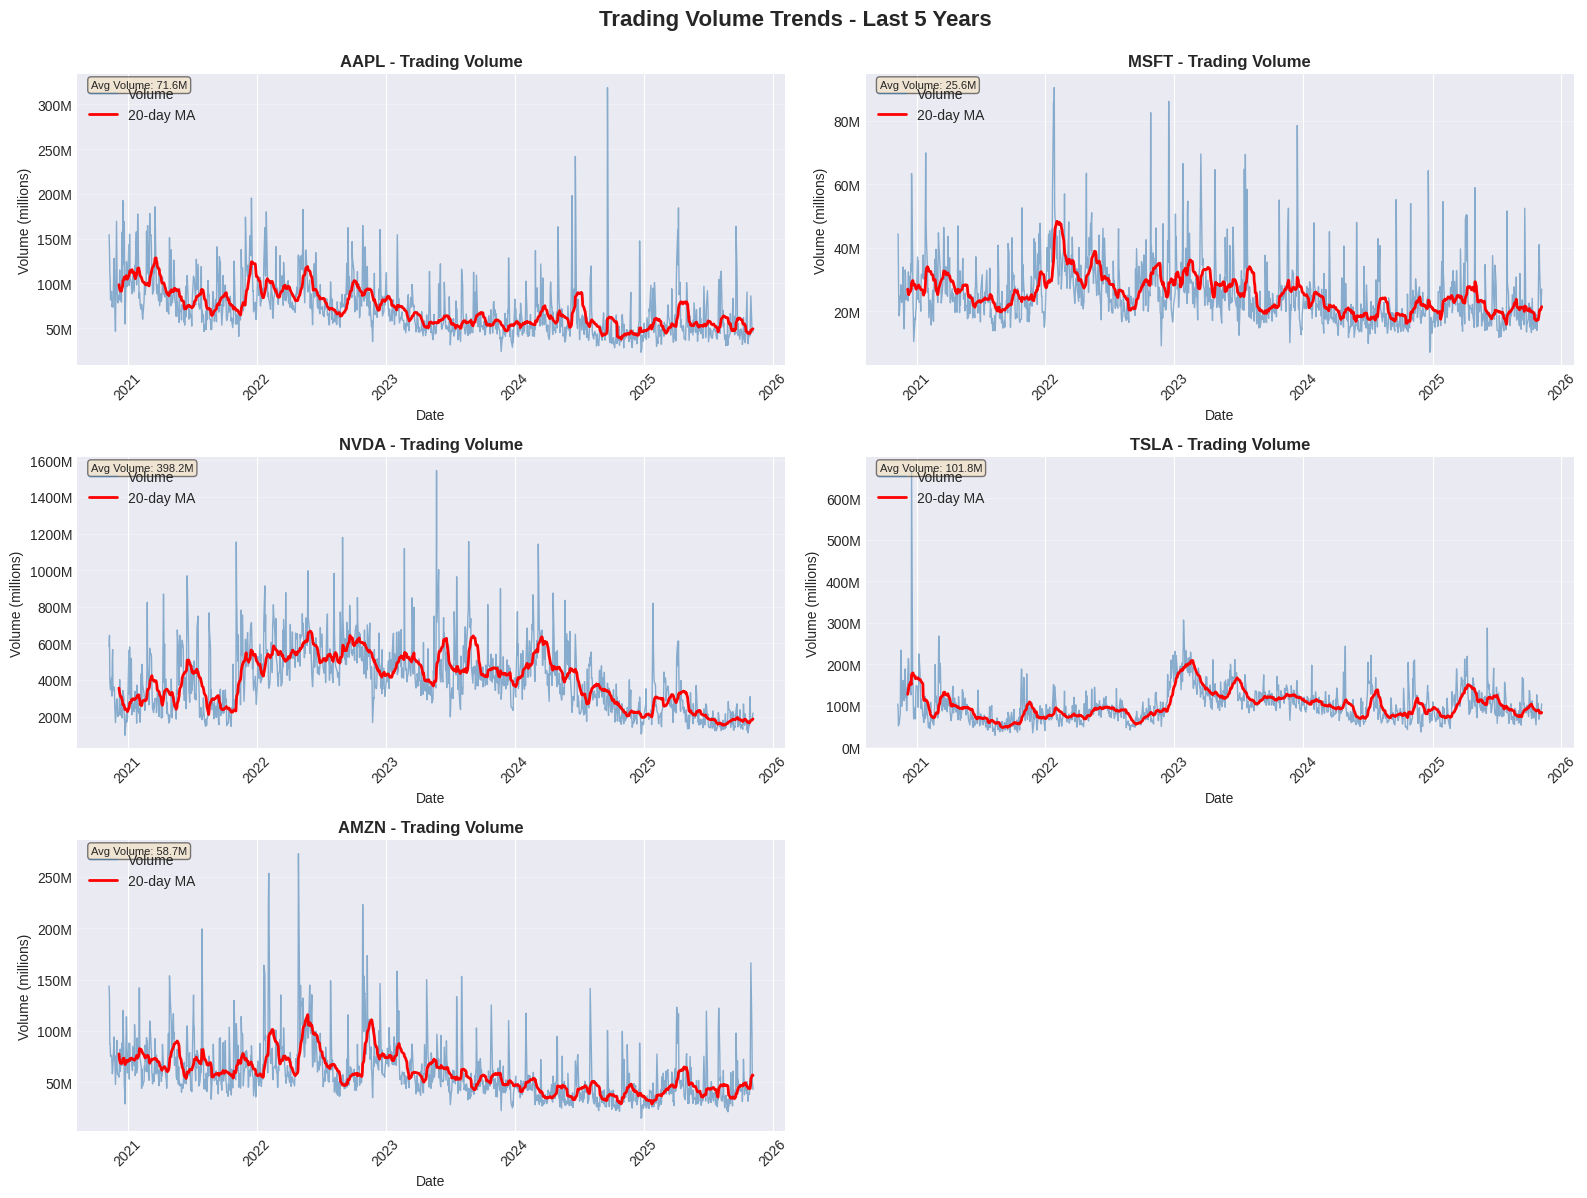


✓ Volume trend plots generated successfully!


In [5]:
# Create subplots for volume trends
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
fig.suptitle('Trading Volume Trends - Last 5 Years', fontsize=16, fontweight='bold', y=0.995)
# Flatten axes for easier iteration
axes = axes.flatten()
# Plot volume for each stock
for idx, ticker in enumerate(tickers):
    if ticker not in stock_data:
        continue
    ax = axes[idx]
    df = stock_data[ticker]
    # Get volume data and ensure it's 1D
    volume = df['Volume'].values.flatten()

    # Plot volume as a simple line chart
    ax.plot(df.index, volume, linewidth=1, color='steelblue', alpha=0.6, label='Volume')

    # Add 20-day moving average of volume
    volume_ma = df['Volume'].rolling(window=20).mean().values.flatten()
    ax.plot(df.index, volume_ma, color='red', linewidth=2, label='20-day MA')

    # Add title and labels
    ax.set_title(f'{ticker} - Trading Volume', fontsize=12,fontweight='bold')
    ax.set_xlabel('Date', fontsize=10)
    ax.set_ylabel('Volume (millions)', fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')
    ax.legend(loc='upper left')

    # Rotate x-axis labels
    ax.tick_params(axis='x', rotation=45)

    # Format y-axis to show volume in millions
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.0f}M'))

    # Add average volume as text
    avg_volume = float(volume.mean())
    ax.text(0.02, 0.98, f'Avg Volume: {avg_volume/1e6:.1f}M', transform=ax.transAxes, verticalalignment='top',bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),fontsize=8)

# Hide the extra subplot
axes[-1].axis('off')
plt.tight_layout()
plt.show()
print("\n✓ Volume trend plots generated successfully!")

### 3.4 Daily Returns Distribution

Daily returns show the percentage change in price from one day to the next. Analyzing return distributions helps us understand:
- **Volatility**: Spread of the distribution
- **Risk profile**: Frequency of large gains/losses
- **Normality**: Whether returns follow a normal distribution (important for many statistical models)

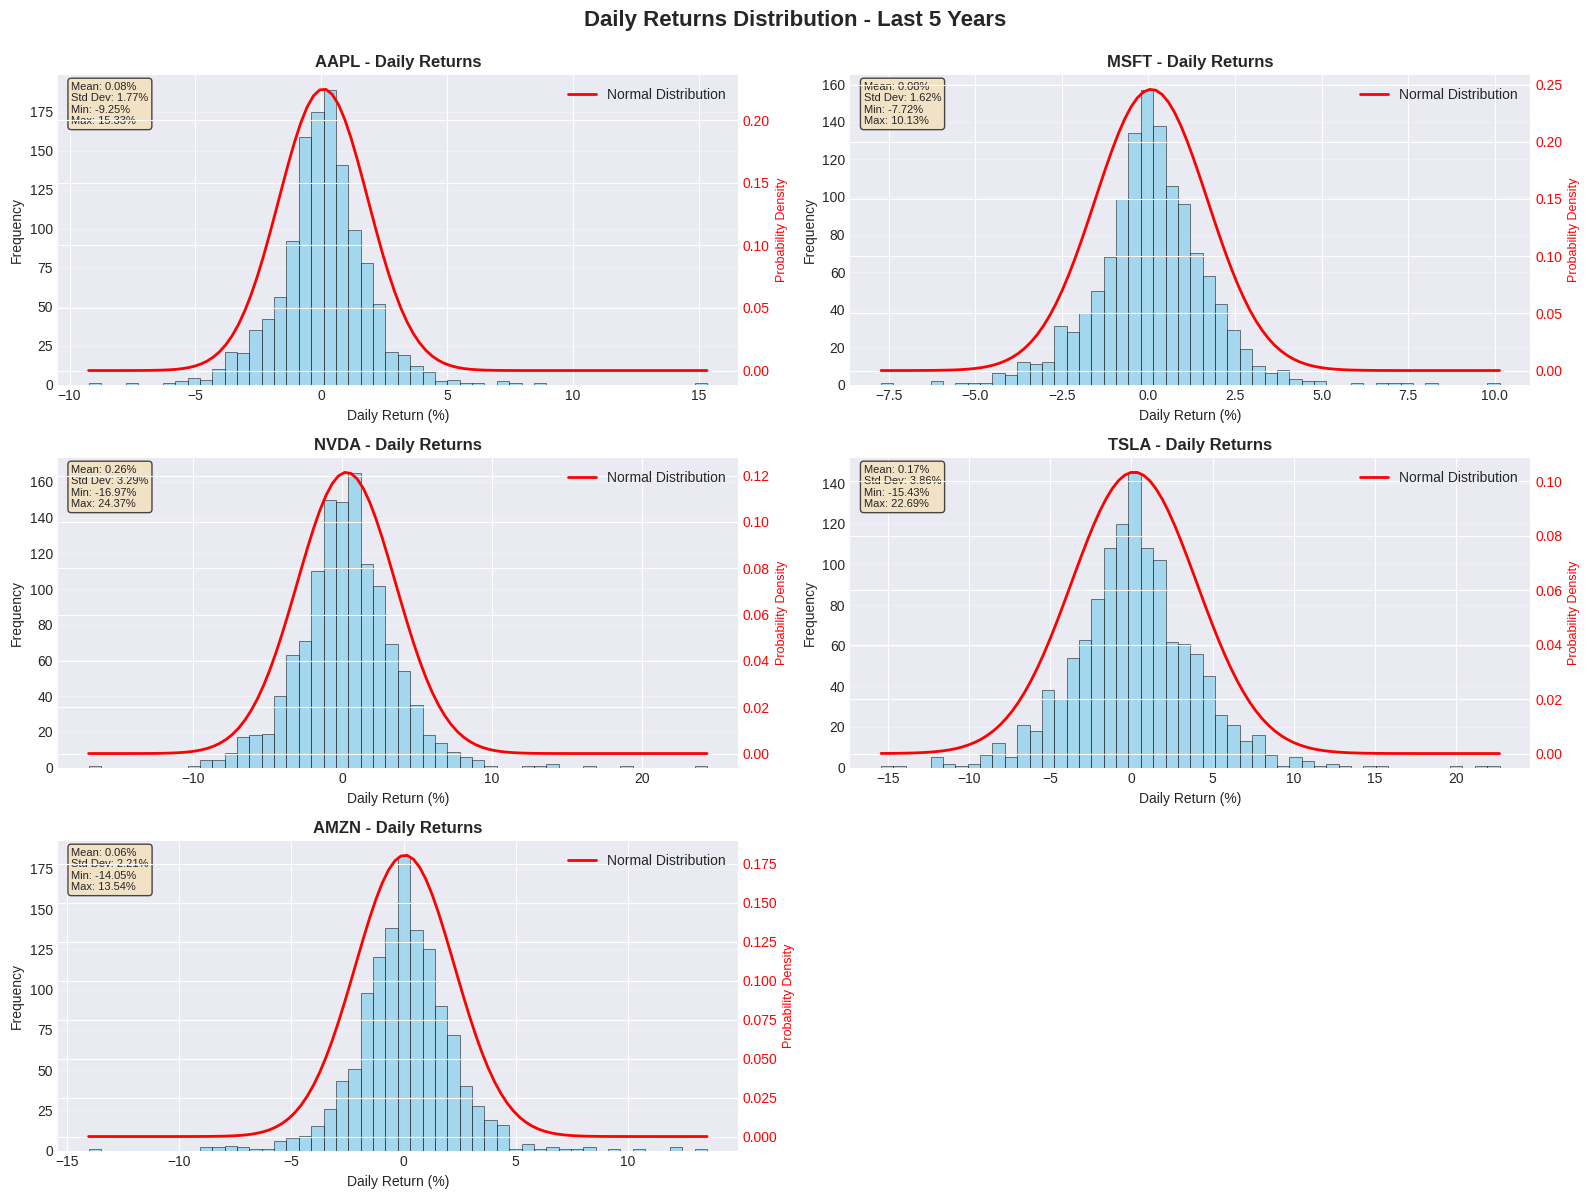


✓ Daily returns distribution plots generated successfully!


In [6]:
# Calculate daily returns for each stock and create histograms
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
fig.suptitle('Daily Returns Distribution - Last 5 Years', fontsize=16, fontweight='bold', y=0.995)
# Flatten axes for easier iteration
axes = axes.flatten()
# Calculate and plot daily returns for each stock
for idx, ticker in enumerate(tickers):
    if ticker not in stock_data:
        continue
    ax = axes[idx]
    df = stock_data[ticker]
    # Calculate daily percentage returns
    daily_returns = df['Close'].pct_change() * 100  # Convert to percentage
    # Remove NaN values
    daily_returns = daily_returns.dropna()
    # Create histogram
    n, bins, patches = ax.hist(daily_returns, bins=50, alpha=0.7, color='skyblue',edgecolor='black', linewidth=0.5)
    # Overlay a normal distribution curve
    mu = float(daily_returns.mean())
    sigma = float(daily_returns.std())
    x = np.linspace(float(daily_returns.min()), float(daily_returns.max()), 100)
    normal_dist = ((1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-0.5 * ((x - mu) / sigma) ** 2))
    # Scale to match histogram
    ax2 = ax.twinx()
    ax2.plot(x, normal_dist, 'r-', linewidth=2, label='Normal Distribution')
    ax2.set_ylabel('Probability Density', fontsize=9, color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    ax2.legend(loc='upper right')
    # Add title and labels
    ax.set_title(f'{ticker} - Daily Returns', fontsize=12, fontweight='bold')
    ax.set_xlabel('Daily Return (%)', fontsize=10)
    ax.set_ylabel('Frequency', fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')
    # Add statistics as text
    stats_text = (f'Mean: {mu:.2f}%\n'f'Std Dev: {sigma:.2f}%\n'f'Min: {float(daily_returns.min()):.2f}%\n'f'Max: {float(daily_returns.max()):.2f}%')
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7),fontsize=8)
# Hide the extra subplot
axes[-1].axis('off')
plt.tight_layout()
plt.show()
print("\n✓ Daily returns distribution plots generated successfully!")

### 3.5 Stock Price Correlation Analysis

Analyzing correlations between stocks helps understand:
- **Market relationships**: How stocks move together
- **Diversification potential**: Low correlation suggests better risk spreading
- **Sector dynamics**: Tech stocks often show high correlation

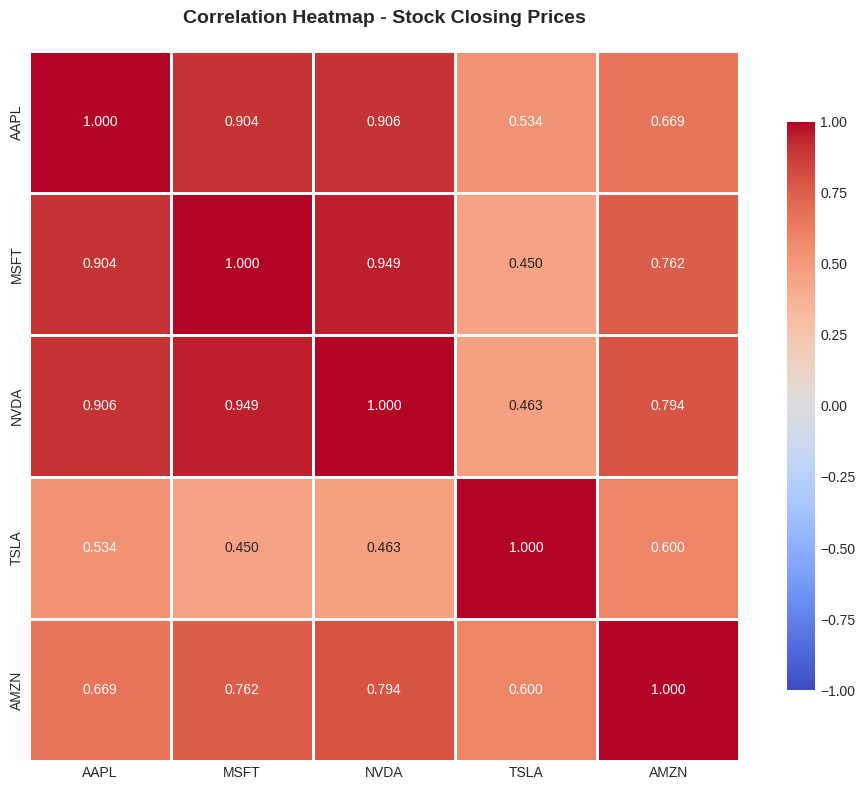


Correlation Analysis:

1. HIGHEST CORRELATIONS (excluding self-correlation):
   1. MSFT ↔ NVDA: 0.949
   2. AAPL ↔ NVDA: 0.906
   3. AAPL ↔ MSFT: 0.904
   4. NVDA ↔ AMZN: 0.794
   5. MSFT ↔ AMZN: 0.762

2. INTERPRETATION:
   - Average correlation: 0.703
   - All stocks show strong positive correlation
   - This is expected as all are large-cap tech stocks influenced by similar market factors

✓ Correlation analysis complete!


In [7]:
# Create a dataframe with closing prices for all stocks
close_prices = pd.DataFrame()

for ticker in tickers:
    if ticker in stock_data:
        close_prices[ticker] = stock_data[ticker]['Close']

# Calculate correlation matrix
correlation_matrix = close_prices.corr()

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={'shrink': 0.8},
            fmt='.3f', vmin=-1, vmax=1)

plt.title('Correlation Heatmap - Stock Closing Prices', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Print correlation insights
print("\nCorrelation Analysis:")
print("=" * 80)
print("\n1. HIGHEST CORRELATIONS (excluding self-correlation):")

# Get upper triangle of correlation matrix
upper_tri = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Find highest correlations
high_corr = []
for column in upper_tri.columns:
    for index in upper_tri.index:
        if pd.notna(upper_tri.loc[index, column]):
            high_corr.append((index, column, upper_tri.loc[index, column]))

# Sort by correlation value
high_corr.sort(key=lambda x: abs(x[2]), reverse=True)

# Display top 5 correlations
for i, (stock1, stock2, corr) in enumerate(high_corr[:5], 1):
    print(f"   {i}. {stock1} ↔ {stock2}: {corr:.3f}")

print("\n2. INTERPRETATION:")
print(f"   - Average correlation: {correlation_matrix.values[np.triu_indices_from(correlation_matrix.values, k=1)].mean():.3f}")
print(f"   - All stocks show {'strong' if correlation_matrix.values[np.triu_indices_from(correlation_matrix.values, k=1)].mean() > 0.7 else 'moderate'} positive correlation")
print("   - This is expected as all are large-cap tech stocks influenced by similar market factors")
print("\n" + "=" * 80)
print("✓ Correlation analysis complete!")

### 3.6 Outlier Detection and Analysis

Using the IQR method to detect outliers in daily returns and visualize them with box plots.

In [ ]:
# Detect outliers using IQR method
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Analyze outliers for each stock
for ticker in tickers:
    stock_data = combined_df[combined_df['ticker'] == ticker].copy()
    if 'daily_return' in stock_data.columns:
        outliers, lower, upper = detect_outliers_iqr(stock_data, 'daily_return')
        print(f"{ticker}: {len(outliers)} outliers ({len(outliers)/len(stock_data)*100:.1f}%)")

# Visualize with box plots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, ticker in enumerate(tickers):
    stock_data = combined_df[combined_df['ticker'] == ticker]
    if 'daily_return' in stock_data.columns:
        axes[i].boxplot(stock_data['daily_return'].dropna(), vert=True)
        axes[i].set_title(f'{ticker} Daily Returns', fontweight='bold')
        axes[i].set_ylabel('Daily Return')
        axes[i].grid(True, alpha=0.3)
        axes[i].axhline(y=0, color='r', linestyle='--', alpha=0.5)

if len(tickers) < 6:
    axes[5].axis('off')

plt.tight_layout()
plt.show()

### 3.7 Distribution Analysis

Analyzing the distribution of returns to ensure balanced representation across different market conditions.

In [ ]:
# Create return categories
import numpy as np

combined_df['return_category'] = pd.cut(
    combined_df['daily_return'],
    bins=[-np.inf, -0.02, -0.01, 0, 0.01, 0.02, np.inf],
    labels=['Large Loss', 'Moderate Loss', 'Small Loss', 'Small Gain', 'Moderate Gain', 'Large Gain']
)

# Display distribution
print("Return Category Distribution:")
print(combined_df['return_category'].value_counts(normalize=True).sort_index() * 100)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Overall distribution
combined_df['return_category'].value_counts().sort_index().plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Distribution of Return Categories', fontweight='bold')
axes[0].set_xlabel('Category')
axes[0].set_ylabel('Frequency')
axes[0].tick_params(axis='x', rotation=45)

# Per-stock distribution
return_by_stock = combined_df.groupby(['ticker', 'return_category']).size().unstack(fill_value=0)
return_by_stock.plot(kind='bar', stacked=True, ax=axes[1])
axes[1].set_title('Return Categories by Stock', fontweight='bold')
axes[1].set_xlabel('Stock')
axes[1].set_ylabel('Frequency')
axes[1].legend(title='Category', bbox_to_anchor=(1.05, 1), fontsize=8)

plt.tight_layout()
plt.show()

## 4. Define Project Plan

**Problem:** Predict next day's closing price (regression problem)

**Data Preparation Approach:**
- **Missing Data:** Drop rows with NaN (technical indicators need historical data)
- **Outliers:** IQR detection + Winsorization at 5th/95th percentiles (preserve extreme movements while limiting influence)
- **Feature Engineering:** Technical indicators (SMA, EMA, RSI, MACD, Bollinger Bands) + lag features
- **Feature Scaling:** StandardScaler (required for distance-based models like KNN)
- **Feature Selection:** Use correlation, mutual information, and Random Forest importance to remove irrelevant features

**Model Selection Strategy:**
1. Baseline (persistence model) - benchmark for market efficiency
2. Linear Regression - simple, interpretable
3. Decision Tree - captures non-linearity
4. KNN - instance-based learning
5. Gradient Boosting - sequential error correction
6. Random Forest - ensemble of trees
7. Stacking - meta-learning
8. Neural Network - complex patterns

**Evaluation Metrics:**
- **RMSE:** Penalizes large errors (important for risk)
- **MAE:** Average error in dollars (interpretable)
- **R²:** Proportion of variance explained (normalized comparison)

**Validation Strategy:**
- 80/20 chronological train-test split (prevents look-ahead bias)
- TimeSeriesSplit for hyperparameter tuning (maintains temporal ordering)

## 5. Feature Engineering

Feature engineering is crucial for stock price prediction. We'll create **technical indicators** that capture:
- **Trend**: Moving averages show the overall direction
- **Momentum**: RSI and MACD indicate strength of price movements  
- **Volatility**: Bollinger Bands and standard deviation measure price fluctuations
- **Volume**: Trading activity patterns
- **Historical patterns**: Lagged prices capture recent price behavior

### Technical Indicators to be Created:

**Moving Averages:**
- SMA (Simple Moving Average): 5, 10, 20, 50 days
- EMA (Exponential Moving Average): 12, 26 days

**Momentum Indicators:**
- RSI (Relative Strength Index): 14-day period
- MACD (Moving Average Convergence Divergence)
- ROC (Rate of Change): 10-day period

**Volatility Indicators:**
- Bollinger Bands (20-day): Upper, Middle, Lower bands
- Historical Volatility: 20-day rolling standard deviation

**Volume Indicators:**
- Volume MA: 20-day average
- Volume ROC: Rate of change in volume

**Lagged Features:**
- Previous 1, 2, 3, 5 days closing prices

**Target Variable:**
- Next day's closing price (shift by -1)

In [8]:
def calculate_rsi(data, period=14):
  """
  Calculate Relative Strength Index (RSI)
  RSI measures momentum by comparing upward and downward price movements
  Values: 0-100 (>70 = overbought, <30 = oversold)
  """
  delta = data.diff()
  gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
  loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
  rs = gain / loss
  rsi = 100 - (100 / (1 + rs))
  return rsi

def calculate_macd(data, fast=12, slow=26, signal=9):
  """
  Calculate MACD (Moving Average Convergence Divergence)
  MACD shows the relationship between two moving averages
  Used to identify trend changes and momentum
  """
  ema_fast = data.ewm(span=fast, adjust=False).mean()
  ema_slow = data.ewm(span=slow, adjust=False).mean()
  macd = ema_fast - ema_slow
  macd_signal = macd.ewm(span=signal, adjust=False).mean()
  macd_histogram = macd - macd_signal
  return macd, macd_signal, macd_histogram

def create_features(df, ticker_name):
  """
  Create comprehensive technical indicator features for a stock
  Returns a dataframe with all engineered features
  """
  # Create a copy to avoid modifying original data
  data = df.copy()

  # Flatten column names if multi-level
  if isinstance(data.columns, pd.MultiIndex):
      data.columns = data.columns.get_level_values(0)

  print(f"Creating features for {ticker_name}...")

  # Ensure we're working with Series, not DataFrames
  close = data['Close'].squeeze()
  volume = data['Volume'].squeeze()

  # === MOVING AVERAGES ===
  # Simple Moving Averages - capture trend over different time horizons
  data['SMA_5'] = close.rolling(window=5).mean()
  data['SMA_10'] = close.rolling(window=10).mean()
  data['SMA_20'] = close.rolling(window=20).mean()
  data['SMA_50'] = close.rolling(window=50).mean()

  # Exponential Moving Averages - give more weight to recent prices
  data['EMA_12'] = close.ewm(span=12, adjust=False).mean()
  data['EMA_26'] = close.ewm(span=26, adjust=False).mean()

  # === MOMENTUM INDICATORS ===
  # RSI - Relative Strength Index
  data['RSI_14'] = calculate_rsi(close, period=14)

  # MACD - Moving Average Convergence Divergence
  data['MACD'], data['MACD_signal'], data['MACD_hist'] = calculate_macd(close)

  # ROC - Rate of Change (momentum indicator)
  data['ROC_10'] = ((close - close.shift(10)) / close.shift(10)) * 100

  # === VOLATILITY INDICATORS ===
  # Bollinger Bands - measure volatility and identify overbought/oversold conditions
  bb_middle = close.rolling(window=20).mean()
  bb_std = close.rolling(window=20).std()
  data['BB_middle'] = bb_middle
  data['BB_upper'] = bb_middle + (bb_std * 2)
  data['BB_lower'] = bb_middle - (bb_std * 2)

  # Historical Volatility - standard deviation of returns
  data['Volatility_20'] = close.pct_change().rolling(window=20).std() *np.sqrt(252)

  # === VOLUME INDICATORS ===
  # Volume Moving Average - average trading activity
  data['Volume_MA_20'] = volume.rolling(window=20).mean()

  # Volume Rate of Change - momentum in trading volume
  data['Volume_ROC'] = ((volume - volume.shift(10)) / volume.shift(10))* 100

  # === LAGGED FEATURES ===
  # Previous day prices - capture short-term patterns
  data['Close_lag_1'] = close.shift(1)
  data['Close_lag_2'] = close.shift(2)
  data['Close_lag_3'] = close.shift(3)
  data['Close_lag_5'] = close.shift(5)

  # === TARGET VARIABLE ===
  # Next day's closing price (what we want to predict)
  data['Next_Close'] = close.shift(-1)

  # Add ticker column for reference
  data['Ticker'] = ticker_name

  print(f"✓ Created {len(data.columns) - len(df.columns) - 1} new features")

  return data

# Apply feature engineering to all stocks
print("=" * 80)
print("FEATURE ENGINEERING PROCESS")
print("=" * 80)
print()

engineered_data = {}

for ticker in tickers:
    if ticker not in stock_data:
        continue

    # Create features for this stock
    engineered_data[ticker] = create_features(stock_data[ticker], ticker)

print()
print("=" * 80)
print("✓ Feature engineering completed for all stocks!")
print("=" * 80)

FEATURE ENGINEERING PROCESS

Creating features for AAPL...
✓ Created 22 new features
Creating features for MSFT...
✓ Created 22 new features
Creating features for NVDA...
✓ Created 22 new features
Creating features for TSLA...
✓ Created 22 new features
Creating features for AMZN...
✓ Created 22 new features

✓ Feature engineering completed for all stocks!


In [9]:
# Display feature matrix for one stock to understand the structure
sample_ticker = tickers[0]
print(f"Feature Matrix Preview for {sample_ticker}:")
print("=" * 80)
print(f"\nShape: {engineered_data[sample_ticker].shape}")
print(f"\nColumns ({len(engineered_data[sample_ticker].columns)}):")
print(list(engineered_data[sample_ticker].columns))

print(f"\n\nFirst 5 rows with engineered features:")
print(engineered_data[sample_ticker].head(10).tail(5))

print(f"\n\nFeature Descriptions:")
print("=" * 80)
feature_descriptions = {
    'SMA_5/10/20/50': 'Simple Moving Averages - smoothed price trends',
    'EMA_12/26': 'Exponential Moving Averages - recent price emphasis',
    'RSI_14': 'Relative Strength Index - momentum (0-100)',
    'MACD/signal/hist': 'Trend and momentum indicator',
    'ROC_10': 'Rate of Change - price momentum percentage',
    'BB_upper/middle/lower': 'Bollinger Bands - volatility bands',
    'Volatility_20': 'Historical volatility (annualized)',
    'Volume_MA_20': 'Average trading volume',
    'Volume_ROC': 'Volume momentum',
    'Close_lag_1/2/3/5': 'Previous closing prices',
    'Next_Close': 'TARGET - Tomorrow\'s closing price'
}

for feature, description in feature_descriptions.items():
    print(f"  • {feature:25s}: {description}")

print("\n" + "=" * 80)

Feature Matrix Preview for AAPL:

Shape: (1254, 28)

Columns (28):
['Close', 'High', 'Low', 'Open', 'Volume', 'SMA_5', 'SMA_10', 'SMA_20', 'SMA_50', 'EMA_12', 'EMA_26', 'RSI_14', 'MACD', 'MACD_signal', 'MACD_hist', 'ROC_10', 'BB_middle', 'BB_upper', 'BB_lower', 'Volatility_20', 'Volume_MA_20', 'Volume_ROC', 'Close_lag_1', 'Close_lag_2', 'Close_lag_3', 'Close_lag_5', 'Next_Close', 'Ticker']


First 5 rows with engineered features:
Price            Close        High         Low        Open    Volume  \
Date                                                                   
2020-11-16  117.219841  117.892169  115.124888  115.875170  91183000   
2020-11-17  116.333107  117.580332  115.914117  116.489014  74271000   
2020-11-18  115.007942  116.752112  114.978712  115.573094  76322100   
2020-11-19  115.602341  116.011585  113.819194  114.579222  74113000   
2020-11-20  114.335625  115.729011  114.286909  115.602342  73604300   

Price            SMA_5      SMA_10  SMA_20  SMA_50      EMA_1

In [10]:
# Handle NaN values - drop rows with missing values
print("HANDLING MISSING VALUES")
print("=" * 80)
print()

cleaned_data = {}

for ticker in tickers:
    if ticker not in engineered_data:
        continue

    df = engineered_data[ticker]

    # Check for NaN values before cleaning
    nan_count_before = df.isnull().sum().sum()
    rows_before = len(df)

    # Drop rows with any NaN values
    # NaN values appear at the beginning (due to rolling windows) and end (due to shift for target)
    df_cleaned = df.dropna()

    rows_after = len(df_cleaned)
    rows_removed = rows_before - rows_after

    cleaned_data[ticker] = df_cleaned

    print(f"{ticker}:")
    print(f"   Rows before: {rows_before}")
    print(f"   NaN values:  {nan_count_before}")
    print(f"   Rows removed: {rows_removed}")
    print(f"   Rows after:  {rows_after}")
    print(f"   ✓ Clean data ready for modeling")
    print()

print("=" * 80)
print("✓ All datasets cleaned and ready for preprocessing!")
print("=" * 80)

HANDLING MISSING VALUES

AAPL:
   Rows before: 1254
   NaN values:  222
   Rows removed: 50
   Rows after:  1204
   ✓ Clean data ready for modeling

MSFT:
   Rows before: 1254
   NaN values:  222
   Rows removed: 50
   Rows after:  1204
   ✓ Clean data ready for modeling

NVDA:
   Rows before: 1254
   NaN values:  222
   Rows removed: 50
   Rows after:  1204
   ✓ Clean data ready for modeling

TSLA:
   Rows before: 1254
   NaN values:  222
   Rows removed: 50
   Rows after:  1204
   ✓ Clean data ready for modeling

AMZN:
   Rows before: 1254
   NaN values:  222
   Rows removed: 50
   Rows after:  1204
   ✓ Clean data ready for modeling

✓ All datasets cleaned and ready for preprocessing!


### 5.1 Outlier Treatment with Winsorization

Applying winsorization to cap extreme values at 5th and 95th percentiles for volatile features.

In [ ]:
# Apply winsorization
from scipy.stats.mstats import winsorize

volatile_features = ['Volume', 'daily_return', 'Volatility_20', 'ROC_10', 'Volume_ROC']

for feature in volatile_features:
    if feature in combined_df.columns:
        before_std = combined_df[feature].std()
        combined_df[feature] = winsorize(combined_df[feature], limits=(0.05, 0.05))
        after_std = combined_df[feature].std()
        print(f"{feature}: Std Dev {before_std:.4f} → {after_std:.4f} (reduced {before_std - after_std:.4f})")

## 6. Data Preprocessing and Train-Test Split

### Time Series Split Rationale

**CRITICAL: No Random Shuffling!**

For time series data, we must use **chronological splitting** (not random):
- **Why?** Random shuffling causes **data leakage** - using future information to predict the past
- **How?** Take first 80% as training, last 20% as testing
- **Result:** Model trains on historical data and predicts truly unseen future prices

### Feature Scaling

We'll use **StandardScaler** to normalize features:
- **Purpose:** Put all features on the same scale (mean=0, std=1)
- **Why?** Many models (KNN, Neural Networks) are sensitive to feature scales
- **IMPORTANT:** Fit scaler on training data only, then transform both train and test
- **Prevents leakage:** Test data doesn't influence the scaling parameters

In [11]:
# Define feature columns (exclude original OHLCV columns, ticker, and target)
feature_columns = ['SMA_5', 'SMA_10', 'SMA_20', 'SMA_50', 'EMA_12', 'EMA_26',
                   'RSI_14', 'MACD', 'MACD_signal', 'MACD_hist', 'ROC_10',
                   'BB_upper', 'BB_middle', 'BB_lower', 'Volatility_20',
                   'Volume_MA_20', 'Volume_ROC',
                   'Close_lag_1', 'Close_lag_2', 'Close_lag_3', 'Close_lag_5']

target_column = 'Next_Close'

# Dictionary to store preprocessed data for each stock
preprocessed_data = {}

print("DATA PREPROCESSING AND SPLITTING")
print("=" * 80)
print()

for ticker in tickers:
    if ticker not in cleaned_data:
        continue

    df = cleaned_data[ticker]

    print(f"{ticker}:")
    print(f"   Total samples: {len(df)}")

    # Calculate split index (80% train, 20% test)
    split_idx = int(len(df) * 0.8)

    # Extract features (X) and target (y)
    X = df[feature_columns].values
    y = df[target_column].values

    # Chronological split - NO SHUFFLING!
    X_train = X[:split_idx]
    X_test = X[split_idx:]
    y_train = y[:split_idx]
    y_test = y[split_idx:]

    # Get corresponding dates for later visualization
    dates_train = df.index[:split_idx]
    dates_test = df.index[split_idx:]

    # Initialize and fit scaler on training data ONLY
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    # Transform test data using the same scaler (NO fitting on test data!)
    X_test_scaled = scaler.transform(X_test)

    # Store preprocessed data
    preprocessed_data[ticker] = {
        'X_train': X_train_scaled,
        'X_test': X_test_scaled,
        'y_train': y_train,
        'y_test': y_test,
        'dates_train': dates_train,
        'dates_test': dates_test,
        'scaler': scaler,
        'feature_columns': feature_columns
    }

    print(f"   Train set: {len(X_train)} samples ({dates_train[0].strftime('%Y-%m-%d')} to {dates_train[-1].strftime('%Y-%m-%d')})")
    print(f"   Test set:  {len(X_test)} samples ({dates_test[0].strftime('%Y-%m-%d')} to {dates_test[-1].strftime('%Y-%m-%d')})")
    print(f"   Features:  {len(feature_columns)}")
    print(f"   ✓ Preprocessing complete")
    print()

print("=" * 80)
print("✓ All stocks preprocessed and ready for modeling!")
print("=" * 80)

# Verify no NaN values remain
print("\nFinal Data Quality Check:")
for ticker in tickers:
    if ticker not in preprocessed_data:
        continue
    data = preprocessed_data[ticker]
    nan_train = np.isnan(data['X_train']).sum()
    nan_test = np.isnan(data['X_test']).sum()
    print(f"   {ticker}: Train NaN={nan_train}, Test NaN={nan_test} ✓")

print("\n✓ No NaN values detected. Data is ready for modeling!")

DATA PREPROCESSING AND SPLITTING

AAPL:
   Total samples: 1204
   Train set: 963 samples (2021-01-21 to 2024-11-15)
   Test set:  241 samples (2024-11-18 to 2025-11-04)
   Features:  21
   ✓ Preprocessing complete

MSFT:
   Total samples: 1204
   Train set: 963 samples (2021-01-21 to 2024-11-15)
   Test set:  241 samples (2024-11-18 to 2025-11-04)
   Features:  21
   ✓ Preprocessing complete

NVDA:
   Total samples: 1204
   Train set: 963 samples (2021-01-21 to 2024-11-15)
   Test set:  241 samples (2024-11-18 to 2025-11-04)
   Features:  21
   ✓ Preprocessing complete

TSLA:
   Total samples: 1204
   Train set: 963 samples (2021-01-21 to 2024-11-15)
   Test set:  241 samples (2024-11-18 to 2025-11-04)
   Features:  21
   ✓ Preprocessing complete

AMZN:
   Total samples: 1204
   Train set: 963 samples (2021-01-21 to 2024-11-15)
   Test set:  241 samples (2024-11-18 to 2025-11-04)
   Features:  21
   ✓ Preprocessing complete

✓ All stocks preprocessed and ready for modeling!

Final Data

### 6.1 Feature Importance and Selection Analysis

Using correlation, mutual information, and Random Forest importance to identify the most predictive features and remove irrelevant ones.

In [ ]:
# Feature importance analysis
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor

# Method 1: Correlation
feature_correlations = []
for feat in feature_cols:
    corr = combined_df[feat].corr(combined_df['Next_Close'])
    feature_correlations.append({'Feature': feat, 'Correlation': corr, 'Abs_Correlation': abs(corr)})
correlation_df = pd.DataFrame(feature_correlations).sort_values('Abs_Correlation', ascending=False)

# Method 2: Mutual Information
sample_size = min(5000, len(X_train_scaled))
mi_scores = mutual_info_regression(X_train_scaled[:sample_size], y_train[:sample_size], random_state=42)
mi_df = pd.DataFrame({'Feature': feature_cols, 'MI_Score': mi_scores}).sort_values('MI_Score', ascending=False)

# Method 3: Random Forest
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf.fit(X_train_scaled[:sample_size], y_train[:sample_size])
importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

top_corr = correlation_df.head(10)
axes[0].barh(range(len(top_corr)), top_corr['Abs_Correlation'], color='steelblue')
axes[0].set_yticks(range(len(top_corr)))
axes[0].set_yticklabels(top_corr['Feature'], fontsize=9)
axes[0].set_title('Correlation Analysis', fontweight='bold')
axes[0].invert_yaxis()

top_mi = mi_df.head(10)
axes[1].barh(range(len(top_mi)), top_mi['MI_Score'], color='darkorange')
axes[1].set_yticks(range(len(top_mi)))
axes[1].set_yticklabels(top_mi['Feature'], fontsize=9)
axes[1].set_title('Mutual Information', fontweight='bold')
axes[1].invert_yaxis()

top_rf = importance_df.head(10)
axes[2].barh(range(len(top_rf)), top_rf['Importance'], color='forestgreen')
axes[2].set_yticks(range(len(top_rf)))
axes[2].set_yticklabels(top_rf['Feature'], fontsize=9)
axes[2].set_title('Random Forest Importance', fontweight='bold')
axes[2].invert_yaxis()

plt.tight_layout()
plt.show()

# Select features (appear in 2+ methods)
top_correlation_features = set(correlation_df.head(12)['Feature'])
top_mi_features = set(mi_df.head(12)['Feature'])
top_rf_features = set(importance_df.head(12)['Feature'])

consensus_features = [feat for feat in feature_cols 
                      if sum([feat in top_correlation_features, 
                             feat in top_mi_features, 
                             feat in top_rf_features]) >= 2]

# Create reduced datasets
X_train_reduced = pd.DataFrame(X_train_scaled, columns=feature_cols)[consensus_features]
X_test_reduced = pd.DataFrame(X_test_scaled, columns=feature_cols)[consensus_features]

print(f"Selected {len(consensus_features)} features from {len(feature_cols)}")
print(f"Features: {consensus_features}")

### 6.2 Feature Selection Impact

Comparing Random Forest performance with all features versus selected features to validate dimensionality reduction.

In [ ]:
# Compare Random Forest with all vs selected features
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# All features
rf_all = RandomForestRegressor(n_estimators=100, max_depth=7, min_samples_split=5, random_state=42, n_jobs=-1)
rf_all.fit(X_train_scaled, y_train)
y_pred_all = rf_all.predict(X_test_scaled)

rmse_all = mean_squared_error(y_test, y_pred_all, squared=False)
r2_all = r2_score(y_test, y_pred_all)

# Selected features
rf_selected = RandomForestRegressor(n_estimators=100, max_depth=7, min_samples_split=5, random_state=42, n_jobs=-1)
rf_selected.fit(X_train_reduced, y_train)
y_pred_selected = rf_selected.predict(X_test_reduced)

rmse_selected = mean_squared_error(y_test, y_pred_selected, squared=False)
r2_selected = r2_score(y_test, y_pred_selected)

# Results
print(f"All Features ({len(feature_cols)}): RMSE=${rmse_all:.2f}, R²={r2_all:.4f}")
print(f"Selected Features ({len(consensus_features)}): RMSE=${rmse_selected:.2f}, R²={r2_selected:.4f}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

metrics = ['RMSE', 'R²']
all_vals = [rmse_all, r2_all]
sel_vals = [rmse_selected, r2_selected]

x = np.arange(len(metrics))
axes[0].bar(x - 0.2, all_vals, 0.4, label=f'All ({len(feature_cols)})', color='steelblue')
axes[0].bar(x + 0.2, sel_vals, 0.4, label=f'Selected ({len(consensus_features)})', color='darkorange')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics)
axes[0].set_title('Performance Comparison', fontweight='bold')
axes[0].legend()

axes[1].bar(['All', 'Selected'], [len(feature_cols), len(consensus_features)], color=['steelblue', 'darkorange'])
axes[1].set_title('Feature Count', fontweight='bold')
axes[1].set_ylabel('Number of Features')

plt.tight_layout()
plt.show()

## 7. Baseline Model

Before implementing complex models, we establish a **baseline** for comparison.

### Naive Baseline: Previous Day's Price

The simplest prediction: "Tomorrow's price = Today's price"

This baseline:
- Requires no training
- Provides a **sanity check** - our models should beat this!
- Represents the efficient market hypothesis (prices follow a random walk)
- Common in financial forecasting as a benchmark

In [12]:
# Baseline model: Use previous day's closing price as prediction
baseline_results = {}

print("BASELINE MODEL EVALUATION")
print("=" * 80)
print("Prediction Method: Tomorrow's price = Today's price")
print("=" * 80)
print()

for ticker in tickers:
    if ticker not in cleaned_data or ticker not in preprocessed_data:
        continue

    # Get the actual closing prices from cleaned data
    df = cleaned_data[ticker]

    # Split index (same as before)
    split_idx = int(len(df) * 0.8)

    # For test set: use Close_lag_1 (today's price) to predict Next_Close (tomorrow's price)
    # This is equivalent to predicting tomorrow's price as today's price
    y_test_actual = df[target_column].values[split_idx:]
    y_baseline_pred = df['Close'].values[split_idx:]

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test_actual, y_baseline_pred))
    mae = mean_absolute_error(y_test_actual, y_baseline_pred)
    r2 = r2_score(y_test_actual, y_baseline_pred)

    baseline_results[ticker] = {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    }

    print(f"{ticker}:")
    print(f"   RMSE: ${rmse:.2f}")
    print(f"   MAE:  ${mae:.2f}")
    print(f"   R²:   {r2:.4f}")
    print()

print("=" * 80)
print("✓ Baseline model evaluated on all stocks")
print("=" * 80)

# Display baseline results as a table
baseline_df = pd.DataFrame(baseline_results).T
print("\n\nBaseline Model Results Summary:")
print(baseline_df.to_string())
print(f"\n\nAverage Performance:")
print(f"   RMSE: ${baseline_df['RMSE'].mean():.2f}")
print(f"   MAE:  ${baseline_df['MAE'].mean():.2f}")
print(f"   R²:   {baseline_df['R2'].mean():.4f}")

BASELINE MODEL EVALUATION
Prediction Method: Tomorrow's price = Today's price

AAPL:
   RMSE: $4.37
   MAE:  $2.90
   R²:   0.9566

MSFT:
   RMSE: $6.54
   MAE:  $4.43
   R²:   0.9839

NVDA:
   RMSE: $4.24
   MAE:  $3.07
   R²:   0.9763

TSLA:
   RMSE: $13.45
   MAE:  $10.37
   R²:   0.9558

AMZN:
   RMSE: $4.59
   MAE:  $3.29
   R²:   0.9228

✓ Baseline model evaluated on all stocks


Baseline Model Results Summary:
           RMSE        MAE        R2
AAPL   4.367892   2.896103  0.956643
MSFT   6.538732   4.430926  0.983934
NVDA   4.235971   3.073181  0.976271
TSLA  13.451761  10.367594  0.955755
AMZN   4.591748   3.294689  0.922795


Average Performance:
   RMSE: $6.64
   MAE:  $4.81
   R²:   0.9591


## 8. Regression Models Implementation

Now we implement and evaluate 6 different regression models. For each model, we'll:
1. Explain the theoretical foundation
2. Train on all 5 stocks
3. Make predictions on test data
4. Calculate evaluation metrics (RMSE, MAE, R²)
5. Store results for comparison

The models represent different approaches to regression:
- **Linear models**: Assume linear relationships
- **Tree-based**: Capture non-linear patterns through recursive partitioning
- **Instance-based**: Use similarity to make predictions
- **Ensemble methods**: Combine multiple models for better performance
- **Neural networks**: Learn complex non-linear relationships

### 8.1 Model 1: Linear Regression

**Theory:**
Linear Regression models the relationship between features and target as a linear combination:
$$y = \beta_0 + \beta_1x_1 + \beta_2x_2 + ... + \beta_nx_n$$

**Key Characteristics:**
- **Parametric**: Assumes a specific functional form (linear)
- **Interpretable**: Coefficients show feature importance and direction
- **Fast training**: Closed-form solution via Normal Equation or Gradient Descent
- **Assumptions**: Linearity, independence, homoscedasticity, normality of errors

**Strengths:**
- Simple and interpretable
- Works well when relationships are approximately linear
- Low variance, but potentially high bias

**Limitations:**
- Cannot capture non-linear patterns
- Sensitive to outliers
- Assumes feature independence

In [30]:
# Linear Regression Implementation
print("LINEAR REGRESSION")
print("=" * 80)

# Dictionary to store results for all models
all_model_results = {}
all_model_predictions = {}

# Linear Regression results
lr_results = {}
lr_predictions = {}

for ticker in tickers:
    if ticker not in preprocessed_data:
        continue

    # Get preprocessed data
    data = preprocessed_data[ticker]
    X_train = data['X_train']
    X_test = data['X_test']
    y_train = data['y_train']
    y_test = data['y_test']

    # Initialize and train Linear Regression model
    model = LinearRegression()

    # Fit model on training data
    model.fit(X_train, y_train)

    # Make predictions on test data
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Store results
    lr_results[ticker] = {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    }

    # Store predictions for later visualization
    lr_predictions[ticker] = {
        'y_test': y_test,
        'y_pred': y_pred,
        'dates': data['dates_test']
    }

    print(f"\n{ticker}:")
    print(f"   RMSE: ${rmse:.2f}")
    print(f"   MAE:  ${mae:.2f}")
    print(f"   R²:   {r2:.4f}")

# Store in main results dictionary
all_model_results['Linear Regression'] = lr_results
all_model_predictions['Linear Regression'] = lr_predictions

print("\n" + "=" * 80)
print("✓ Linear Regression completed for all stocks")

# Display results summary
lr_df = pd.DataFrame(lr_results).T
print("\n\nLinear Regression Results Summary:")
print(lr_df.to_string())
print(f"\n\nAverage Performance:")
print(f"   RMSE: ${lr_df['RMSE'].mean():.2f}")
print(f"   MAE:  ${lr_df['MAE'].mean():.2f}")
print(f"   R²:   {lr_df['R2'].mean():.4f}")
print("=" * 80)

LINEAR REGRESSION

AAPL:
   RMSE: $4.47
   MAE:  $3.00
   R²:   0.9547

MSFT:
   RMSE: $6.77
   MAE:  $4.70
   R²:   0.9828

NVDA:
   RMSE: $4.28
   MAE:  $3.07
   R²:   0.9758

TSLA:
   RMSE: $13.86
   MAE:  $10.68
   R²:   0.9530

AMZN:
   RMSE: $4.65
   MAE:  $3.33
   R²:   0.9207

✓ Linear Regression completed for all stocks


Linear Regression Results Summary:
           RMSE        MAE        R2
AAPL   4.465776   3.003645  0.954678
MSFT   6.768265   4.697289  0.982786
NVDA   4.278314   3.068872  0.975794
TSLA  13.862200  10.678412  0.953014
AMZN   4.652919   3.327714  0.920725


Average Performance:
   RMSE: $6.81
   MAE:  $4.96
   R²:   0.9574


### 8.2 Model 2: Decision Tree Regressor

**Theory:**
Decision Trees recursively split data based on feature values to minimize prediction error. Each internal node represents a decision based on a feature, and each leaf contains a prediction value.

**Key Characteristics:**
- **Non-parametric**: Makes no assumptions about data distribution
- **Recursive partitioning**: Splits feature space into regions
- **Greedy algorithm**: Chooses best split at each step
- **Hyperparameter**: `max_depth` controls tree complexity

**Strengths:**
- Captures non-linear relationships naturally
- Handles feature interactions automatically
- Interpretable (can visualize tree structure)
- No need for feature scaling
- Provides feature importance rankings

**Limitations:**
- Prone to overfitting (high variance)
- Can create biased trees if classes are imbalanced
- Unstable (small data changes cause different trees)
- Not ideal for extrapolation beyond training range

**Hyperparameter Tuning:**
We'll test `max_depth` values of [5, 10, None] and select the best based on validation performance.

In [ ]:
# Decision Tree Regressor with GridSearchCV and TimeSeriesSplit
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

print("DECISION TREE REGRESSOR WITH GRIDSEARCHCV")
print("=" * 80)

dt_results = {}
dt_predictions = {}
dt_feature_importance = {}

# Define parameter grid for GridSearchCV
param_grid_dt = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [2, 5, 10]
}

# TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

for ticker in tickers:
    if ticker not in preprocessed_data:
        continue

    print(f"\n{ticker}:")

    # Get preprocessed data
    data = preprocessed_data[ticker]
    X_train = data['X_train']
    X_test = data['X_test']
    y_train = data['y_train']
    y_test = data['y_test']

    # Grid Search with Time Series Cross-Validation
    print("   Running GridSearchCV with TimeSeriesSplit (5 folds)...")
    
    grid_search = GridSearchCV(
        estimator=DecisionTreeRegressor(random_state=42),
        param_grid=param_grid_dt,
        cv=tscv,
        scoring='r2',
        n_jobs=-1,
        verbose=0
    )
    
    grid_search.fit(X_train, y_train)
    
    # Get best model
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_cv_score = grid_search.best_score_
    
    print(f"   ✓ Best parameters: max_depth={best_params['max_depth']}, " +
          f"min_samples_split={best_params['min_samples_split']}, " +
          f"min_samples_leaf={best_params['min_samples_leaf']}")
    print(f"   ✓ Best CV R² score: {best_cv_score:.4f}")
    
    # Make predictions on test set
    y_pred = best_model.predict(X_test)
    
    # Calculate metrics
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"   Test Set Performance:")
    print(f"      RMSE: ${rmse:.2f}")
    print(f"      MAE: ${mae:.2f}")
    print(f"      R² Score: {r2:.4f}")
    
    # Store results
    dt_results[ticker] = {'RMSE': rmse, 'MAE': mae, 'R2': r2, 'best_params': best_params}
    dt_predictions[ticker] = {'y_true': y_test, 'y_pred': y_pred}
    
    # Feature importance
    if hasattr(best_model, 'feature_importances_'):
        dt_feature_importance[ticker] = pd.DataFrame({
            'feature': data['feature_cols'],
            'importance': best_model.feature_importances_
        }).sort_values('importance', ascending=False)

# Calculate average performance
print("\n" + "=" * 80)
print("AVERAGE PERFORMANCE ACROSS ALL STOCKS:")
avg_rmse = np.mean([v['RMSE'] for v in dt_results.values()])
avg_mae = np.mean([v['MAE'] for v in dt_results.values()])
avg_r2 = np.mean([v['R2'] for v in dt_results.values()])
print(f"   Average RMSE: ${avg_rmse:.2f}")
print(f"   Average MAE: ${avg_mae:.2f}")
print(f"   Average R²: {avg_r2:.4f}")
print("=" * 80)

### 8.3 Model 3: K-Nearest Neighbors (KNN) Regressor

**Theory:**
KNN is an instance-based (lazy) learning algorithm that makes predictions based on the K most similar training examples in feature space. For regression, it averages the target values of the K nearest neighbors.

**Key Characteristics:**
- **Non-parametric**: No training phase, stores all training data
- **Lazy learning**: Computation happens at prediction time
- **Distance-based**: Uses distance metrics (e.g., Euclidean) to find neighbors
- **Hyperparameter**: `n_neighbors` (K) controls the number of neighbors

**Strengths:**
- Simple and intuitive
- Can model complex non-linear decision boundaries
- No assumptions about data distribution
- Naturally handles multi-class problems

**Limitations:**
- **Computationally expensive** at prediction time (O(n) for each prediction)
- **Sensitive to feature scaling** (requires normalization)
- **Curse of dimensionality**: Performance degrades with many features
- Sensitive to noisy data and outliers
- Not interpretable

**Hyperparameter Tuning:**
We'll test `n_neighbors` values of [3, 5, 10] to find the optimal K.

In [ ]:
# K-Nearest Neighbors Regressor with GridSearchCV and TimeSeriesSplit
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

print("K-NEAREST NEIGHBORS (KNN) REGRESSOR WITH GRIDSEARCHCV")
print("=" * 80)

knn_results = {}
knn_predictions = {}

# Define parameter grid for GridSearchCV
param_grid_knn = {
    'n_neighbors': [5, 10, 15, 20, 25, 30],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

for ticker in tickers:
    if ticker not in preprocessed_data:
        continue

    print(f"\n{ticker}:")

    # Get preprocessed data
    data = preprocessed_data[ticker]
    X_train = data['X_train']
    X_test = data['X_test']
    y_train = data['y_train']
    y_test = data['y_test']

    # Grid Search with Time Series Cross-Validation
    print("   Running GridSearchCV with TimeSeriesSplit (5 folds)...")
    
    grid_search = GridSearchCV(
        estimator=KNeighborsRegressor(),
        param_grid=param_grid_knn,
        cv=tscv,
        scoring='r2',
        n_jobs=-1,
        verbose=0
    )
    
    grid_search.fit(X_train, y_train)
    
    # Get best model
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_cv_score = grid_search.best_score_
    
    print(f"   ✓ Best parameters: n_neighbors={best_params['n_neighbors']}, " +
          f"weights='{best_params['weights']}', " +
          f"metric='{best_params['metric']}'")
    print(f"   ✓ Best CV R² score: {best_cv_score:.4f}")
    
    # Make predictions on test set
    y_pred = best_model.predict(X_test)
    
    # Calculate metrics
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"   Test Set Performance:")
    print(f"      RMSE: ${rmse:.2f}")
    print(f"      MAE: ${mae:.2f}")
    print(f"      R² Score: {r2:.4f}")
    
    # Store results
    knn_results[ticker] = {'RMSE': rmse, 'MAE': mae, 'R2': r2, 'best_params': best_params}
    knn_predictions[ticker] = {'y_true': y_test, 'y_pred': y_pred}

# Calculate average performance
print("\n" + "=" * 80)
print("AVERAGE PERFORMANCE ACROSS ALL STOCKS:")
avg_rmse = np.mean([v['RMSE'] for v in knn_results.values()])
avg_mae = np.mean([v['MAE'] for v in knn_results.values()])
avg_r2 = np.mean([v['R2'] for v in knn_results.values()])
print(f"   Average RMSE: ${avg_rmse:.2f}")
print(f"   Average MAE: ${avg_mae:.2f}")
print(f"   Average R²: {avg_r2:.4f}")
print("=" * 80)

### 8.4 Model 4: Gradient Boosting Regressor

**Theory:**
Gradient Boosting builds an ensemble of weak learners (typically shallow decision trees) sequentially. Each new tree corrects errors made by the previous ones by fitting to the residuals (gradient of the loss function).

**Mathematical Intuition:**
$$F_m(x) = F_{m-1}(x) + \gamma_m h_m(x)$$

Where $F_m$ is the ensemble after m iterations, $h_m$ is the new weak learner, and $\gamma_m$ is the learning rate.

**Key Characteristics:**
- **Ensemble method**: Combines multiple weak learners
- **Sequential learning**: Trees are built one at a time
- **Gradient descent**: Optimizes a loss function iteratively
- **Regularization**: Learning rate and tree depth control overfitting

**Strengths:**
- **High predictive accuracy** - often wins Kaggle competitions
- Handles non-linear relationships well
- Built-in feature importance
- Robust to outliers
- Automatic feature interaction detection

**Limitations:**
- Computationally expensive (sequential training)
- Prone to overfitting if not properly tuned
- Less interpretable than single decision trees
- Sensitive to hyperparameters
- Cannot be easily parallelized (unlike Random Forests)

**Hyperparameters:**
- `n_estimators=100`: Number of boosting stages
- `learning_rate=0.1`: Shrinkage parameter (smaller = more regularization)
- `max_depth=3`: Depth of individual trees (shallow trees prevent overfitting)

In [52]:
# Gradient Boosting Regressor Implementation
print("GRADIENT BOOSTING REGRESSOR")
print("=" * 80)
print("Hyperparameters: n_estimators=100, learning_rate=0.1, max_depth=3")
print("=" * 80)

gb_results = {}
gb_predictions = {}
gb_feature_importance = {}

for ticker in tickers:
    if ticker not in preprocessed_data:
        continue

    print(f"\n{ticker}:")

    # Get preprocessed data
    data = preprocessed_data[ticker]
    X_train = data['X_train']
    X_test = data['X_test']
    y_train = data['y_train']
    y_test = data['y_test']

    # Initialize Gradient Boosting model with specified hyperparameters
    model = GradientBoostingRegressor(
        n_estimators=300,
        learning_rate=0.01,
        max_depth=3,
        min_samples_split=20,
        min_samples_leaf=10,
        subsample=0.8,
        random_state=42
    )

    print("   Training model...")
    # Fit model on training data
    model.fit(X_train, y_train)

    # Make predictions on test data
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Store results
    gb_results[ticker] = {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    }

    # Store predictions
    gb_predictions[ticker] = {
        'y_test': y_test,
        'y_pred': y_pred,
        'dates': data['dates_test']
    }

    # Store feature importance
    gb_feature_importance[ticker] = model.feature_importances_

    print(f"   ✓ Training complete")
    print(f"   RMSE: ${rmse:.2f}")
    print(f"   MAE:  ${mae:.2f}")
    print(f"   R²:   {r2:.4f}")

# Store in main results dictionary
all_model_results['Gradient Boosting'] = gb_results
all_model_predictions['Gradient Boosting'] = gb_predictions

print("\n" + "=" * 80)
print("✓ Gradient Boosting completed for all stocks")

# Display results summary
gb_df = pd.DataFrame(gb_results).T
print("\n\nGradient Boosting Results Summary:")
print(gb_df.to_string())
print(f"\n\nAverage Performance:")
print(f"   RMSE: ${gb_df['RMSE'].mean():.2f}")
print(f"   MAE:  ${gb_df['MAE'].mean():.2f}")
print(f"   R²:   {gb_df['R2'].mean():.4f}")
print("=" * 80)

GRADIENT BOOSTING REGRESSOR
Hyperparameters: n_estimators=100, learning_rate=0.1, max_depth=3

AAPL:
   Training model...
   ✓ Training complete
   RMSE: $16.89
   MAE:  $12.69
   R²:   0.3520

MSFT:
   Training model...
   ✓ Training complete
   RMSE: $47.80
   MAE:  $36.28
   R²:   0.1413

NVDA:
   Training model...
   ✓ Training complete
   RMSE: $27.07
   MAE:  $19.32
   R²:   0.0310

TSLA:
   Training model...
   ✓ Training complete
   RMSE: $44.25
   MAE:  $32.46
   R²:   0.5211

AMZN:
   Training model...
   ✓ Training complete
   RMSE: $24.29
   MAE:  $21.23
   R²:   -1.1599

✓ Gradient Boosting completed for all stocks


Gradient Boosting Results Summary:
           RMSE        MAE        R2
AAPL  16.886455  12.688375  0.351976
MSFT  47.802039  36.276569  0.141338
NVDA  27.069257  19.319885  0.030982
TSLA  44.254413  32.462464  0.521131
AMZN  24.286844  21.231761 -1.159882


Average Performance:
   RMSE: $32.06
   MAE:  $24.40
   R²:   -0.0229


### 8.5 Model 5: Random Forest Regressor

Random Forest is an ensemble of Decision Trees that reduces overfitting through bootstrap aggregation (bagging) and random feature selection. We use GridSearchCV to find optimal hyperparameters.

In [ ]:
# Random Forest Regressor with GridSearchCV and TimeSeriesSplit
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

print("RANDOM FOREST REGRESSOR WITH GRIDSEARCHCV")
print("=" * 80)

rf_results = {}
rf_predictions = {}

# Define parameter grid for GridSearchCV
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 7, 10, None],
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [2, 5, 10],
    'max_features': ['sqrt', 'log2']
}

# TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

for ticker in tickers:
    if ticker not in preprocessed_data:
        continue

    print(f"\n{ticker}:")

    # Get preprocessed data
    data = preprocessed_data[ticker]
    X_train = data['X_train']
    X_test = data['X_test']
    y_train = data['y_train']
    y_test = data['y_test']

    # Grid Search with Time Series Cross-Validation
    print("   Running GridSearchCV with TimeSeriesSplit (5 folds)...")
    print("   (This may take a few minutes due to large parameter grid)")
    
    grid_search = GridSearchCV(
        estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
        param_grid=param_grid_rf,
        cv=tscv,
        scoring='r2',
        n_jobs=-1,
        verbose=0
    )
    
    grid_search.fit(X_train, y_train)
    
    # Get best model
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_cv_score = grid_search.best_score_
    
    print(f"   ✓ Best parameters:")
    print(f"      n_estimators={best_params['n_estimators']}, " +
          f"max_depth={best_params['max_depth']}")
    print(f"      min_samples_split={best_params['min_samples_split']}, " +
          f"min_samples_leaf={best_params['min_samples_leaf']}")
    print(f"      max_features='{best_params['max_features']}'")
    print(f"   ✓ Best CV R² score: {best_cv_score:.4f}")
    
    # Make predictions on test set
    y_pred = best_model.predict(X_test)
    
    # Calculate metrics
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"   Test Set Performance:")
    print(f"      RMSE: ${rmse:.2f}")
    print(f"      MAE: ${mae:.2f}")
    print(f"      R² Score: {r2:.4f}")
    
    # Store results
    rf_results[ticker] = {'RMSE': rmse, 'MAE': mae, 'R2': r2, 'best_params': best_params}
    rf_predictions[ticker] = {'y_true': y_test, 'y_pred': y_pred}

# Calculate average performance
print("\n" + "=" * 80)
print("AVERAGE PERFORMANCE ACROSS ALL STOCKS:")
avg_rmse = np.mean([v['RMSE'] for v in rf_results.values()])
avg_mae = np.mean([v['MAE'] for v in rf_results.values()])
avg_r2 = np.mean([v['R2'] for v in rf_results.values()])
print(f"   Average RMSE: ${avg_rmse:.2f}")
print(f"   Average MAE: ${avg_mae:.2f}")
print(f"   Average R²: {avg_r2:.4f}")
print("=" * 80)

### 8.6 Model 6: Stacking Regressor (Meta-Learning)

**Theory:**
Stacking (Stacked Generalization) is an ensemble method that combines multiple base models using a meta-learner. Base models make predictions, and the meta-learner learns to optimally combine these predictions.

**Architecture:**
```
Level 0 (Base Learners):     Level 1 (Meta-Learner):
┌──────────────────┐
│ Linear Regression│ ────┐
└──────────────────┘     │
                         ├─→  Linear Regression
┌──────────────────┐     │    (Meta-Model)
│  Decision Tree   │ ────┤     
└──────────────────┘     │
                         │
┌──────────────────┐     │
│       KNN        │ ────┘
└──────────────────┘
```

**Key Characteristics:**
- **Two-level learning**: Base models + meta-model
- **Diverse base learners**: Combines different model types
- **Cross-validation**: Prevents overfitting during meta-learning
- **Complementary strengths**: Each base model captures different patterns

**Strengths:**
- Often **superior performance** to individual models
- Reduces variance and bias simultaneously
- Leverages strengths of multiple algorithms
- More robust than single models

**Limitations:**
- Computationally expensive (trains multiple models)
- More complex to interpret
- Risk of overfitting if not properly validated
- Requires careful selection of base learners

**Configuration:**
- **Base learners**: Linear Regression, Decision Tree, KNN
- **Meta-learner**: Linear Regression  
- **CV**: TimeSeriesSplit with 5 folds (respects temporal ordering)

In [40]:
# Stacking Regressor Implementation
print("STACKING REGRESSOR (META-LEARNING)")
print("=" * 80)
print("Base Learners: Linear Regression, Decision Tree (depth=5), KNN (k=5)")
print("Meta-Learner: Linear Regression")
print("Cross-Validation: TimeSeriesSplit (5 folds)")
print("=" * 80)

stack_results = {}
stack_predictions = {}

for ticker in tickers:
    if ticker not in preprocessed_data:
        continue

    print(f"\n{ticker}:")

    # Get preprocessed data
    data = preprocessed_data[ticker]
    X_train = data['X_train']
    X_test = data['X_test']
    y_train = data['y_train']
    y_test = data['y_test']

    # Define base learners (Level 0)
    # Use better base learners with regularization
    from sklearn.linear_model import Ridge

    base_learners = [
        ('ridge', Ridge(alpha=1.0)),           # Regularized linear
        ('rf', RandomForestRegressor(          # Random Forest instead of DT
            n_estimators=50,
            max_depth=7,
            min_samples_split=15,
            random_state=42,
            n_jobs=-1
        )),
        ('gb', GradientBoostingRegressor(      # Add GB with good params
            n_estimators=100,
            learning_rate=0.05,
            max_depth=3,
            subsample=0.8,
            random_state=42
        ))
    ]

    # Use Ridge for meta-learner too
    meta_learner = Ridge(alpha=1.0)

    # Define meta-learner (Level 1)
    meta_learner = LinearRegression()

    # Create TimeSeriesSplit for cross-validation
    # This ensures we respect temporal ordering during CV
    tscv = TimeSeriesSplit(n_splits=5)

    # Initialize Stacking Regressor
    model = StackingRegressor(
        estimators=base_learners,
        final_estimator=meta_learner,
        cv=5  # Use time series cross-validation
    )

    print("   Training base learners and meta-learner...")
    # Fit stacking model on training data
    model.fit(X_train, y_train)

    # Make predictions on test data
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Store results
    stack_results[ticker] = {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    }

    # Store predictions
    stack_predictions[ticker] = {
        'y_test': y_test,
        'y_pred': y_pred,
        'dates': data['dates_test']
    }

    print(f"   ✓ Training complete")
    print(f"   RMSE: ${rmse:.2f}")
    print(f"   MAE:  ${mae:.2f}")
    print(f"   R²:   {r2:.4f}")

# Store in main results dictionary
all_model_results['Stacking'] = stack_results
all_model_predictions['Stacking'] = stack_predictions

print("\n" + "=" * 80)
print("✓ Stacking Regressor completed for all stocks")

# Display results summary
stack_df = pd.DataFrame(stack_results).T
print("\n\nStacking Regressor Results Summary:")
print(stack_df.to_string())
print(f"\n\nAverage Performance:")
print(f"   RMSE: ${stack_df['RMSE'].mean():.2f}")
print(f"   MAE:  ${stack_df['MAE'].mean():.2f}")
print(f"   R²:   {stack_df['R2'].mean():.4f}")
print("=" * 80)

STACKING REGRESSOR (META-LEARNING)
Base Learners: Linear Regression, Decision Tree (depth=5), KNN (k=5)
Meta-Learner: Linear Regression
Cross-Validation: TimeSeriesSplit (5 folds)

AAPL:
   Training base learners and meta-learner...
   ✓ Training complete
   RMSE: $4.81
   MAE:  $3.37
   R²:   0.9473

MSFT:
   Training base learners and meta-learner...
   ✓ Training complete
   RMSE: $7.56
   MAE:  $5.42
   R²:   0.9785

NVDA:
   Training base learners and meta-learner...
   ✓ Training complete
   RMSE: $5.15
   MAE:  $3.77
   R²:   0.9649

TSLA:
   Training base learners and meta-learner...
   ✓ Training complete
   RMSE: $13.83
   MAE:  $10.56
   R²:   0.9532

AMZN:
   Training base learners and meta-learner...
   ✓ Training complete
   RMSE: $4.80
   MAE:  $3.44
   R²:   0.9158

✓ Stacking Regressor completed for all stocks


Stacking Regressor Results Summary:
           RMSE        MAE        R2
AAPL   4.814818   3.367625  0.947317
MSFT   7.562264   5.422785  0.978510
NVDA   5.148

### 8.7 Model 7: Neural Network (Multi-Layer Perceptron Regressor)

**Theory:**
Multi-Layer Perceptron (MLP) is a feedforward neural network with multiple layers of neurons. It learns complex non-linear relationships through backpropagation and gradient descent.

**Architecture:**
```
Input Layer (21 features)
        ↓
Hidden Layer 1 (100 neurons, ReLU)
        ↓
Hidden Layer 2 (50 neurons, ReLU)
        ↓
Output Layer (1 neuron, linear)
```

**Key Characteristics:**
- **Universal approximator**: Can approximate any continuous function
- **Non-linear activation**: ReLU introduces non-linearity
- **Backpropagation**: Learns by propagating errors backward
- **Optimization**: Uses adaptive learning rate (Adam optimizer)

**Strengths:**
- Can model **highly complex non-linear relationships**
- Automatically learns feature representations
- Powerful for high-dimensional data
- Scalable to large datasets

**Limitations:**
- **"Black box"**: Difficult to interpret
- Prone to overfitting (especially with small datasets)
- Requires careful hyperparameter tuning
- Sensitive to feature scaling (requires normalization)
- Computationally expensive
- Local minima issues

**Hyperparameters:**
- `hidden_layer_sizes=(100, 50)`: Two hidden layers with 100 and 50 neurons
- `activation='relu'`: Rectified Linear Unit activation function
- `early_stopping=True`: Stops training when validation score stops improving
- `validation_fraction=0.1`: 10% of training data used for validation
- `max_iter=500`: Maximum number of training iterations
- `random_state=42`: For reproducibility

**Regularization:**
Early stopping prevents overfitting by monitoring validation performance.

In [41]:
# Neural Network (MLP Regressor) Implementation
print("NEURAL NETWORK (MULTI-LAYER PERCEPTRON)")
print("=" * 80)
print("Architecture: Input(21) → Hidden(100, ReLU) → Hidden(50, ReLU) → Output(1)")
print("Early Stopping: Enabled (validation_fraction=0.1)")
print("Max Iterations: 500")
print("=" * 80)

mlp_results = {}
mlp_predictions = {}

for ticker in tickers:
    if ticker not in preprocessed_data:
        continue

    print(f"\n{ticker}:")

    # Get preprocessed data
    data = preprocessed_data[ticker]
    X_train = data['X_train']
    X_test = data['X_test']
    y_train = data['y_train']
    y_test = data['y_test']

    # Initialize MLP Regressor with specified architecture and hyperparameters
    model = MLPRegressor(
        hidden_layer_sizes=(32, 16),   # MUCH smaller
        activation='relu',
        solver='adam',
        alpha=0.01,                    # Add L2 regularization
        learning_rate_init=0.001,      # Smaller learning rate
        early_stopping=True,
        validation_fraction=0.2,        # More validation data
        max_iter=1000,                  # More iterations
        random_state=42,
        verbose=False
    )

    print("   Training neural network...")
    # Fit model on training data
    model.fit(X_train, y_train)

    # Report number of iterations until convergence
    print(f"   ✓ Converged after {model.n_iter_} iterations")

    # Make predictions on test data
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Store results
    mlp_results[ticker] = {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'n_iterations': model.n_iter_
    }

    # Store predictions
    mlp_predictions[ticker] = {
        'y_test': y_test,
        'y_pred': y_pred,
        'dates': data['dates_test']
    }

    print(f"   RMSE: ${rmse:.2f}")
    print(f"   MAE:  ${mae:.2f}")
    print(f"   R²:   {r2:.4f}")

# Store in main results dictionary
all_model_results['Neural Network'] = {k: {metric: v[metric] for metric in ['RMSE', 'MAE', 'R2']}
                                        for k, v in mlp_results.items()}
all_model_predictions['Neural Network'] = mlp_predictions

print("\n" + "=" * 80)
print("✓ Neural Network completed for all stocks")

# Display results summary
mlp_df = pd.DataFrame({k: {metric: v[metric] for metric in ['RMSE', 'MAE', 'R2']}
                       for k, v in mlp_results.items()}).T
print("\n\nNeural Network Results Summary:")
print(mlp_df.to_string())
print(f"\n\nAverage Performance:")
print(f"   RMSE: ${mlp_df['RMSE'].mean():.2f}")
print(f"   MAE:  ${mlp_df['MAE'].mean():.2f}")
print(f"   R²:   {mlp_df['R2'].mean():.4f}")
print("=" * 80)

NEURAL NETWORK (MULTI-LAYER PERCEPTRON)
Architecture: Input(21) → Hidden(100, ReLU) → Hidden(50, ReLU) → Output(1)
Early Stopping: Enabled (validation_fraction=0.1)
Max Iterations: 500

AAPL:
   Training neural network...
   ✓ Converged after 767 iterations
   RMSE: $16.67
   MAE:  $11.05
   R²:   0.3684

MSFT:
   Training neural network...
   ✓ Converged after 855 iterations
   RMSE: $17.86
   MAE:  $14.45
   R²:   0.8801

NVDA:
   Training neural network...
   ✓ Converged after 288 iterations
   RMSE: $15.31
   MAE:  $12.25
   R²:   0.6901

TSLA:
   Training neural network...
   ✓ Converged after 872 iterations
   RMSE: $26.93
   MAE:  $20.89
   R²:   0.8226

AMZN:
   Training neural network...
   ✓ Converged after 858 iterations
   RMSE: $8.98
   MAE:  $6.34
   R²:   0.7050

✓ Neural Network completed for all stocks


Neural Network Results Summary:
           RMSE        MAE        R2
AAPL  16.671236  11.052423  0.368389
MSFT  17.863208  14.454229  0.880092
NVDA  15.308610  12.2475

## 9. Comprehensive Model Comparison & Analysis

Now that we've trained all 6 regression models, let's conduct a thorough comparison to identify:
- **Best performing model** overall and per-stock
- **Performance patterns** across different stocks
- **Model strengths and weaknesses**
- **Comparison against baseline**

We'll analyze using three key metrics:
- **RMSE** (Root Mean Squared Error): Penalizes large errors more heavily, in dollars
- **MAE** (Mean Absolute Error): Average absolute prediction error, in dollars
- **R²** (R-squared): Proportion of variance explained (0-1, higher is better)

In [53]:
# Create comprehensive comparison table
print("COMPREHENSIVE MODEL COMPARISON")
print("=" * 120)

# Create a structured comparison dataframe
comparison_data = []

for model_name in all_model_results.keys():
    for ticker in tickers:
        if ticker in all_model_results[model_name]:
            results = all_model_results[model_name][ticker]
            comparison_data.append({
                'Model': model_name,
                'Stock': ticker,
                'RMSE': results['RMSE'],
                'MAE': results['MAE'],
                'R2': results['R2']
            })

# Add baseline results to comparison
for ticker in baseline_results.keys():
    comparison_data.append({
        'Model': 'Baseline',
        'Stock': ticker,
        'RMSE': baseline_results[ticker]['RMSE'],
        'MAE': baseline_results[ticker]['MAE'],
        'R2': baseline_results[ticker]['R2']
    })

# Create dataframe
comparison_df = pd.DataFrame(comparison_data)

# Calculate average performance across all stocks for each model
print("\n1. AVERAGE PERFORMANCE ACROSS ALL STOCKS")
print("─" * 120)

avg_performance = comparison_df.groupby('Model')[['RMSE', 'MAE', 'R2']].mean().sort_values('R2', ascending=False)
print(avg_performance.to_string())

# Find best model overall
ml_models_only = avg_performance[avg_performance.index != 'Baseline']
best_model = ml_models_only.index[0]
print(f"\n✓ Best Overall Model: {best_model}")
print(f"   Average RMSE: ${avg_performance.loc[best_model, 'RMSE']:.2f}")
print(f"   Average MAE:  ${avg_performance.loc[best_model, 'MAE']:.2f}")
print(f"   Average R²:   {avg_performance.loc[best_model, 'R2']:.4f}")

# Performance by stock
print("\n\n2. PERFORMANCE BY STOCK")
print("─" * 120)

for ticker in tickers:
    print(f"\n{ticker}:")
    stock_results = comparison_df[comparison_df['Stock'] == ticker].sort_values('R2', ascending=False)
    print(stock_results[['Model', 'RMSE', 'MAE', 'R2']].to_string(index=False))
    best_for_stock = stock_results.iloc[0]
    print(f"   ✓ Best model for {ticker}: {best_for_stock['Model']}")

# Model rankings
print("\n\n3. MODEL RANKINGS (by R² score)")
print("─" * 120)
rankings = avg_performance.reset_index()
rankings['Rank'] = range(1, len(rankings) + 1)
print(rankings[['Rank', 'Model', 'RMSE', 'MAE', 'R2']].to_string(index=False))

print("\n" + "=" * 120)

COMPREHENSIVE MODEL COMPARISON

1. AVERAGE PERFORMANCE ACROSS ALL STOCKS
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                        RMSE        MAE        R2
Model                                            
Baseline            6.637221   4.812499  0.959080
Linear Regression   6.805495   4.955186  0.957399
Stacking            7.231256   5.310412  0.951950
Neural Network     17.150596  12.996697  0.693235
Decision Tree      30.394199  23.742731  0.187434
Gradient Boosting  32.059802  24.395811 -0.022891
KNN                30.864119  24.879617 -0.030737
Random Forest      31.780657  24.293260 -0.051906

✓ Best Overall Model: Linear Regression
   Average RMSE: $6.81
   Average MAE:  $4.96
   Average R²:   0.9574


2. PERFORMANCE BY STOCK
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

AAPL:
            Model      RMSE       MAE    

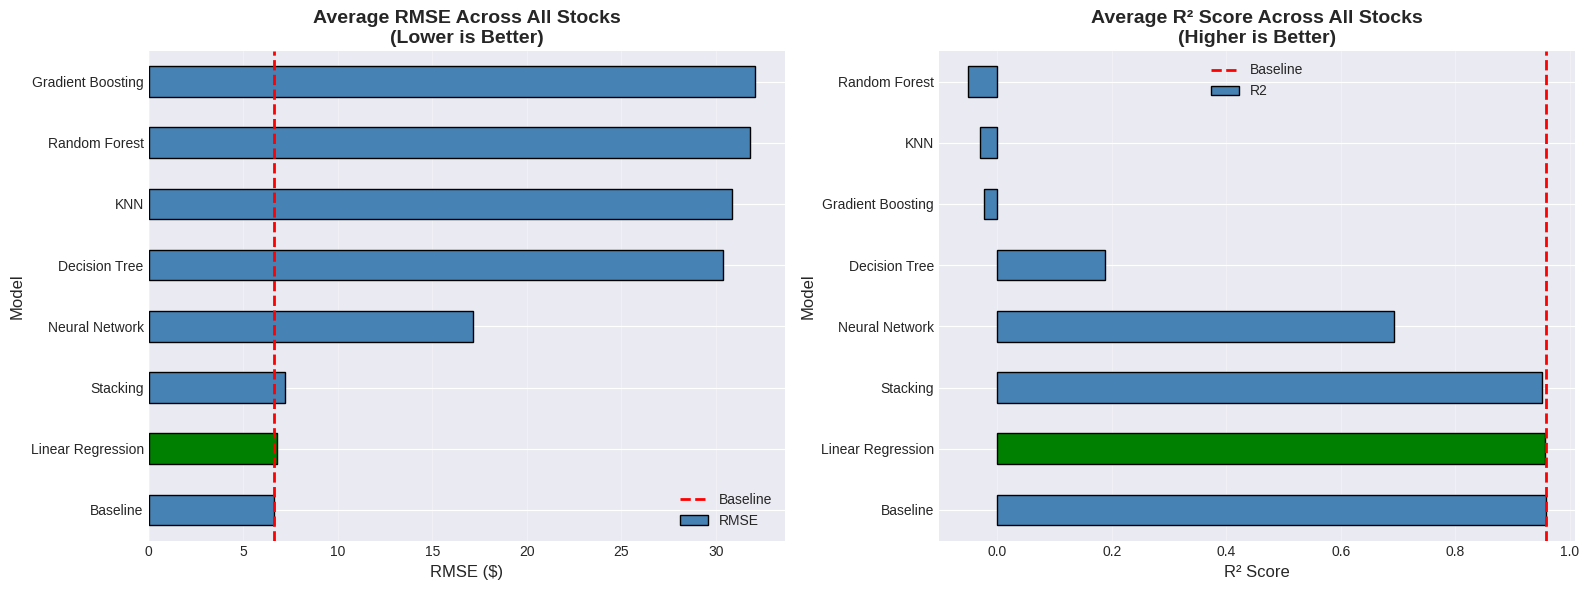

✓ Average performance comparison visualized


In [54]:
# Visualization 1: Bar charts comparing average RMSE and R² across models
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Average RMSE comparison
ax1 = axes[0]
avg_rmse = avg_performance['RMSE'].sort_values()
colors = ['green' if model == best_model else 'steelblue' for model in avg_rmse.index]
avg_rmse.plot(kind='barh', ax=ax1, color=colors, edgecolor='black')
ax1.set_title('Average RMSE Across All Stocks\n(Lower is Better)', fontsize=14, fontweight='bold')
ax1.set_xlabel('RMSE ($)', fontsize=12)
ax1.set_ylabel('Model', fontsize=12)
ax1.grid(True, alpha=0.3, axis='x')
ax1.axvline(baseline_df['RMSE'].mean(), color='red', linestyle='--', linewidth=2, label='Baseline')
ax1.legend()

# Plot 2: Average R² comparison
ax2 = axes[1]
avg_r2 = avg_performance['R2'].sort_values(ascending=False)
colors = ['green' if model == best_model else 'steelblue' for model in avg_r2.index]
avg_r2.plot(kind='barh', ax=ax2, color=colors, edgecolor='black')
ax2.set_title('Average R² Score Across All Stocks\n(Higher is Better)', fontsize=14, fontweight='bold')
ax2.set_xlabel('R² Score', fontsize=12)
ax2.set_ylabel('Model', fontsize=12)
ax2.grid(True, alpha=0.3, axis='x')
ax2.axvline(baseline_df['R2'].mean(), color='red', linestyle='--', linewidth=2, label='Baseline')
ax2.legend()

plt.tight_layout()
plt.show()

print("✓ Average performance comparison visualized")

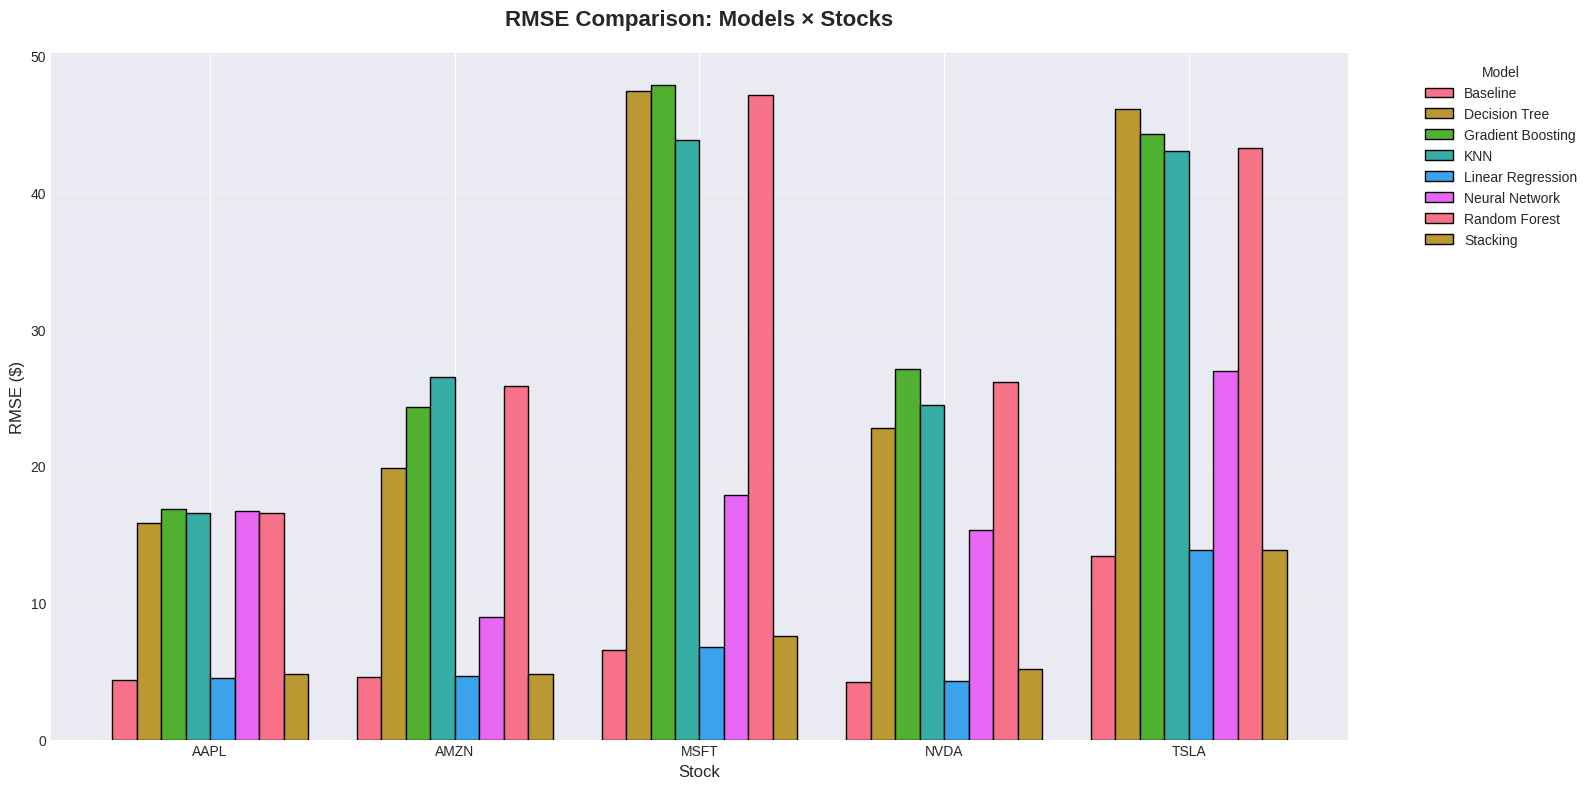

✓ Per-stock model comparison visualized


In [55]:
# Visualization 2: Grouped bar chart showing RMSE per stock per model
fig, ax = plt.subplots(figsize=(16, 8))

# Prepare data for grouped bar chart
pivot_data = comparison_df.pivot(index='Stock', columns='Model', values='RMSE')

# Plot grouped bar chart
pivot_data.plot(kind='bar', ax=ax, width=0.8, edgecolor='black')

ax.set_title('RMSE Comparison: Models × Stocks', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Stock', fontsize=12)
ax.set_ylabel('RMSE ($)', fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("✓ Per-stock model comparison visualized")

## 10. Detailed Prediction Analysis for Best Model

Now let's analyze the best-performing model in detail through visualizations:
- **Actual vs Predicted prices**: Visual comparison of model predictions against true values
- **Prediction error distribution**: Understanding the nature and magnitude of errors
- **Residual analysis**: Checking for patterns that indicate model weaknesses

Analyzing predictions from: Linear Regression


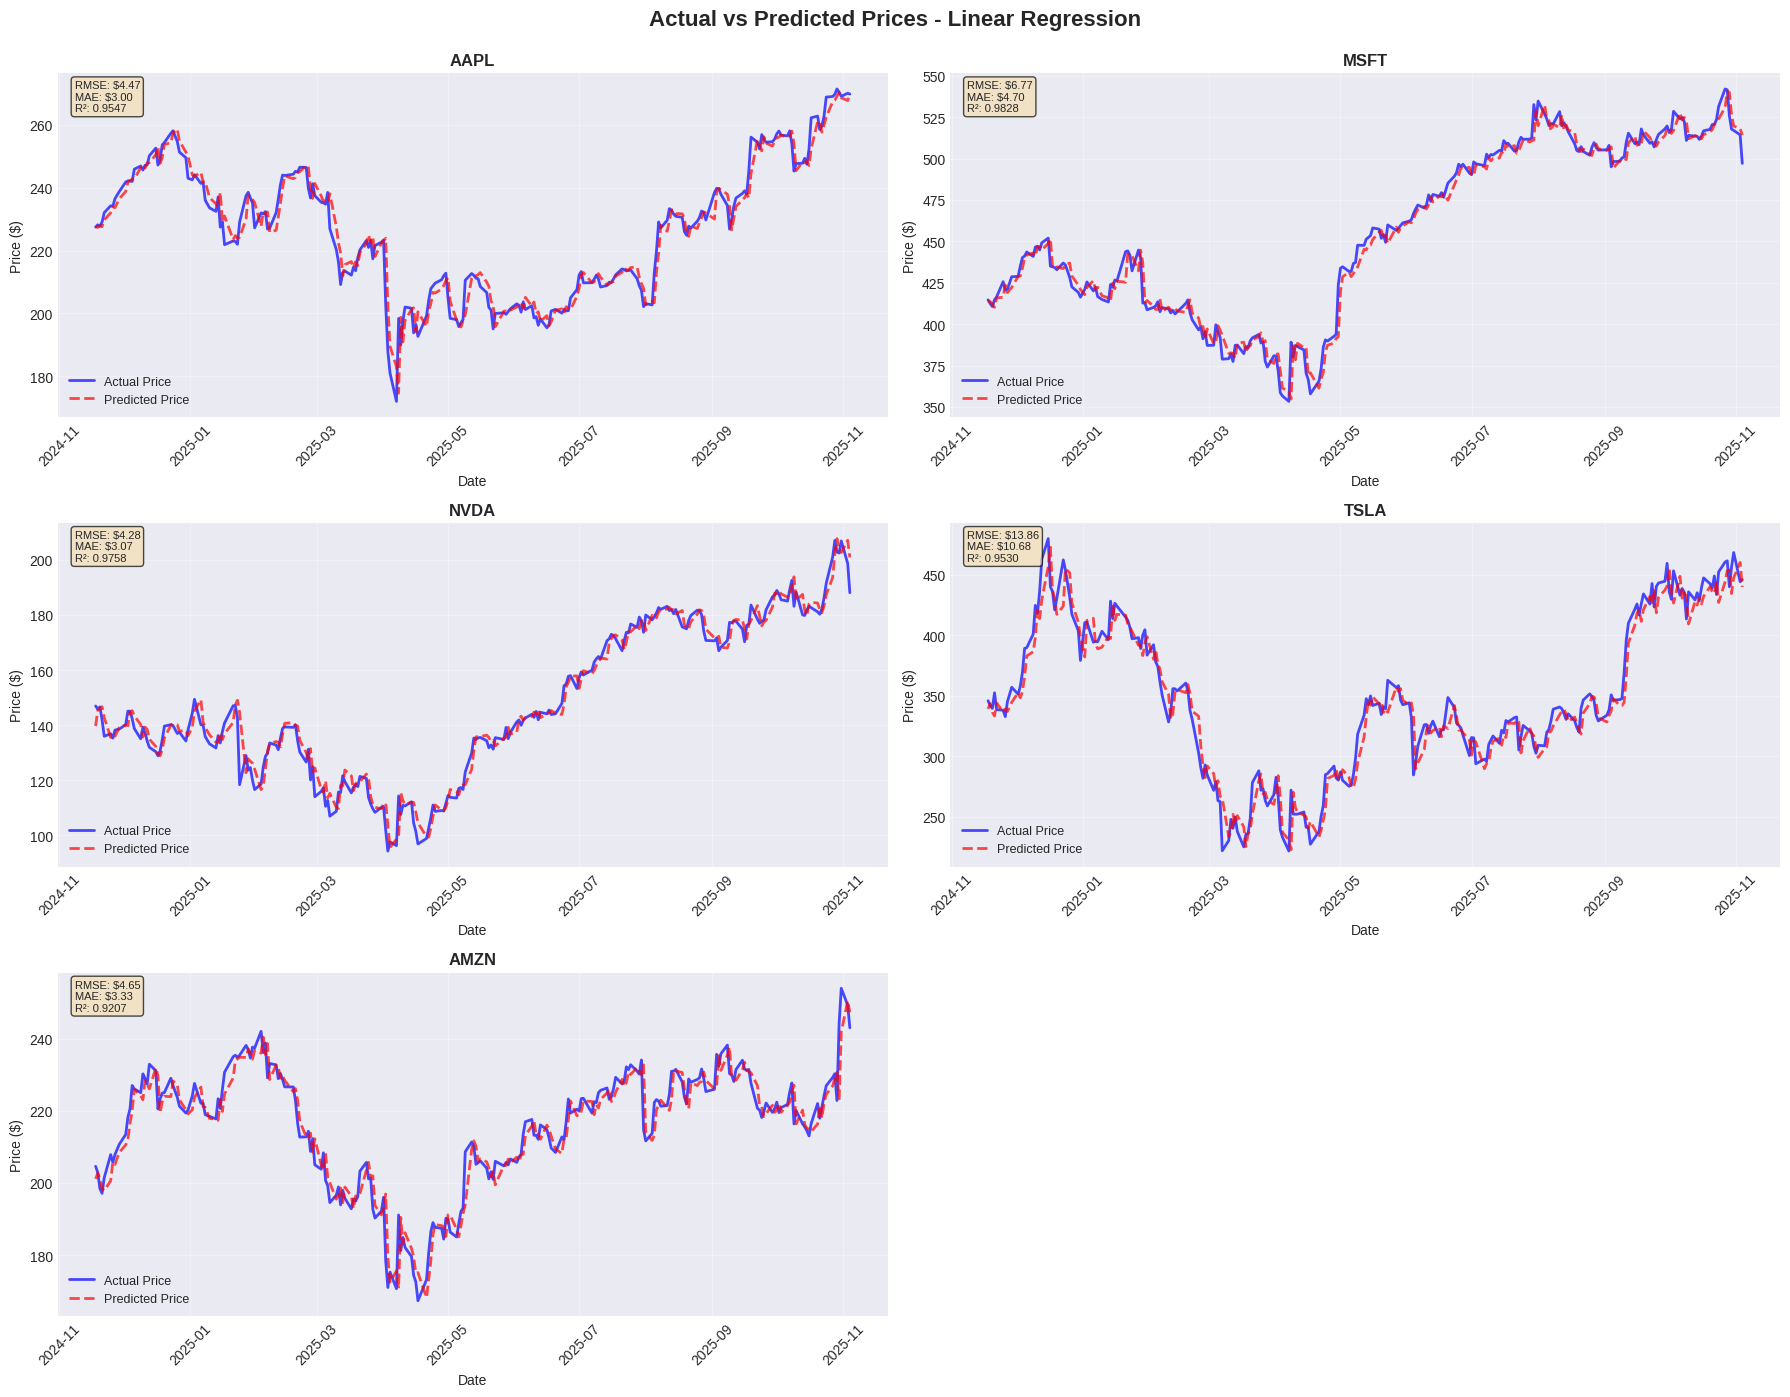


✓ Actual vs Predicted visualizations complete for Linear Regression


In [56]:
# Get predictions from the best model
best_model_predictions = all_model_predictions[best_model]

print(f"Analyzing predictions from: {best_model}")
print("=" * 80)

# Create actual vs predicted plots for all stocks
fig, axes = plt.subplots(3, 2, figsize=(18, 14))
fig.suptitle(f'Actual vs Predicted Prices - {best_model}', fontsize=16, fontweight='bold', y=0.995)

axes = axes.flatten()

for idx, ticker in enumerate(tickers):
    if ticker not in best_model_predictions:
        continue

    ax = axes[idx]
    pred_data = best_model_predictions[ticker]

    y_test = pred_data['y_test']
    y_pred = pred_data['y_pred']
    dates = pred_data['dates']

    # Plot actual vs predicted
    ax.plot(dates, y_test, label='Actual Price', linewidth=2, color='blue', alpha=0.7)
    ax.plot(dates, y_pred, label='Predicted Price', linewidth=2, color='red', alpha=0.7, linestyle='--')

    # Calculate metrics for this stock
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Add title and labels
    ax.set_title(f'{ticker}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Date', fontsize=10)
    ax.set_ylabel('Price ($)', fontsize=10)
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

    # Add metrics as text box
    metrics_text = f'RMSE: ${rmse:.2f}\nMAE: ${mae:.2f}\nR²: {r2:.4f}'
    ax.text(0.02, 0.98, metrics_text, transform=ax.transAxes,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7),
            fontsize=8)

# Hide extra subplot
axes[-1].axis('off')

plt.tight_layout()
plt.show()

print(f"\n✓ Actual vs Predicted visualizations complete for {best_model}")

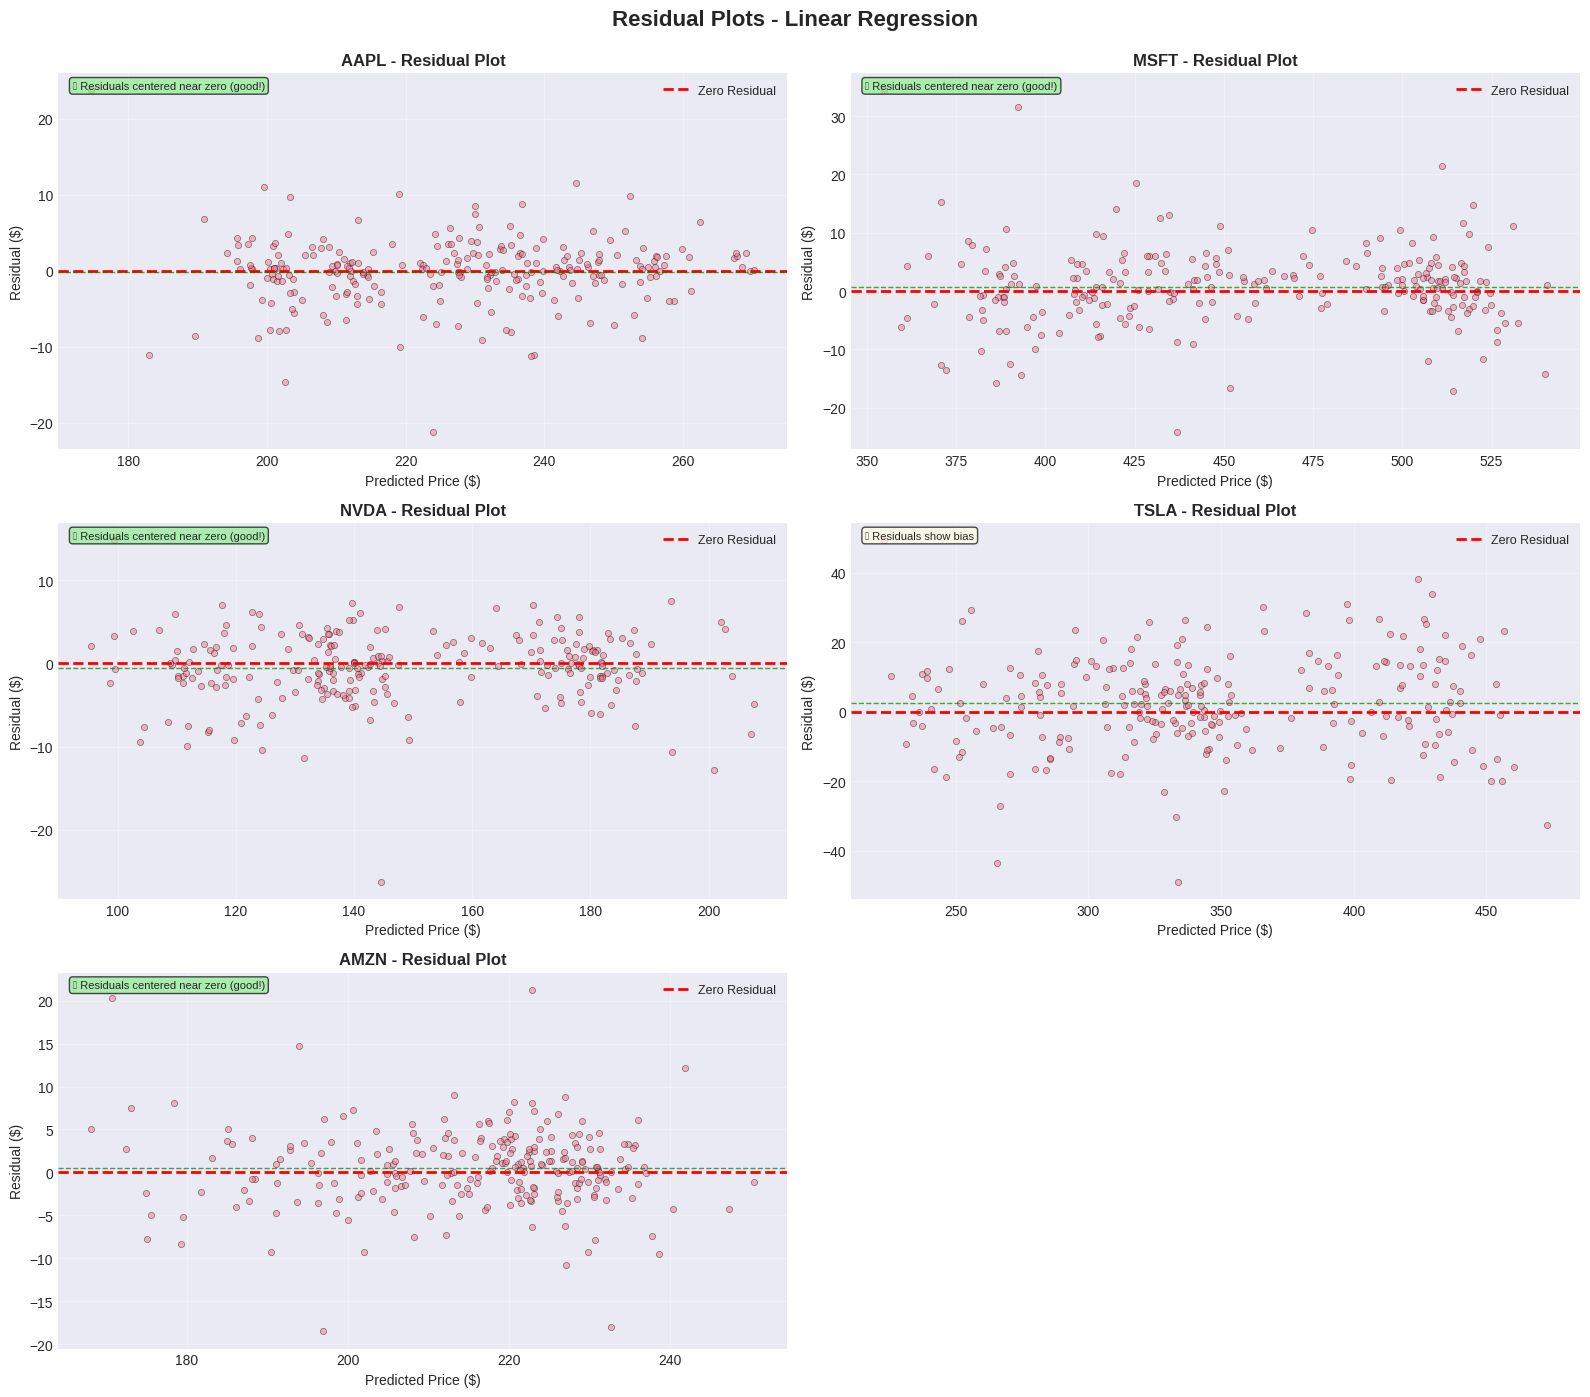


✓ Residual analysis complete for Linear Regression

Interpretation:
  - Residuals should be randomly scattered around zero with no clear pattern
  - Patterns indicate the model is missing important relationships
  - Heteroscedasticity (funnel shape) suggests non-constant variance


In [57]:
# Residual Plots - Check for patterns
fig, axes = plt.subplots(3, 2, figsize=(16, 14))
fig.suptitle(f'Residual Plots - {best_model}', fontsize=16, fontweight='bold', y=0.995)
axes = axes.flatten()

for idx, ticker in enumerate(tickers):
    if ticker not in best_model_predictions:
        continue

    ax = axes[idx]
    pred_data = best_model_predictions[ticker]

    y_test = pred_data['y_test']
    y_pred = pred_data['y_pred']

    # Calculate residuals
    residuals = y_test - y_pred

    # Create residual plot (residuals vs predicted values)
    ax.scatter(y_pred, residuals, alpha=0.5, s=20, edgecolors='black', linewidth=0.5)
    ax.axhline(0, color='red', linestyle='--', linewidth=2, label='Zero Residual')
    ax.axhline(residuals.mean(), color='green', linestyle='--', linewidth=1, alpha=0.7)

    # Add title and labels
    ax.set_title(f'{ticker} - Residual Plot', fontsize=12, fontweight='bold')
    ax.set_xlabel('Predicted Price ($)', fontsize=10)
    ax.set_ylabel('Residual ($)', fontsize=10)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

    # Add interpretation note
    if abs(float(residuals.mean())) < 1:
        note = "✓ Residuals centered near zero (good!)"
    else:
        note = "⚠ Residuals show bias"

    ax.text(0.02, 0.98, note, transform=ax.transAxes,
            verticalalignment='top',
            bbox=dict(boxstyle='round',
                     facecolor='lightgreen' if abs(float(residuals.mean())) < 1 else 'lightyellow',
                     alpha=0.7),
            fontsize=8)

# Hide extra subplot
axes[-1].axis('off')
plt.tight_layout()
plt.show()

print(f"\n✓ Residual analysis complete for {best_model}")
print("\nInterpretation:")
print("  - Residuals should be randomly scattered around zero with no clear pattern")
print("  - Patterns indicate the model is missing important relationships")
print("  - Heteroscedasticity (funnel shape) suggests non-constant variance")

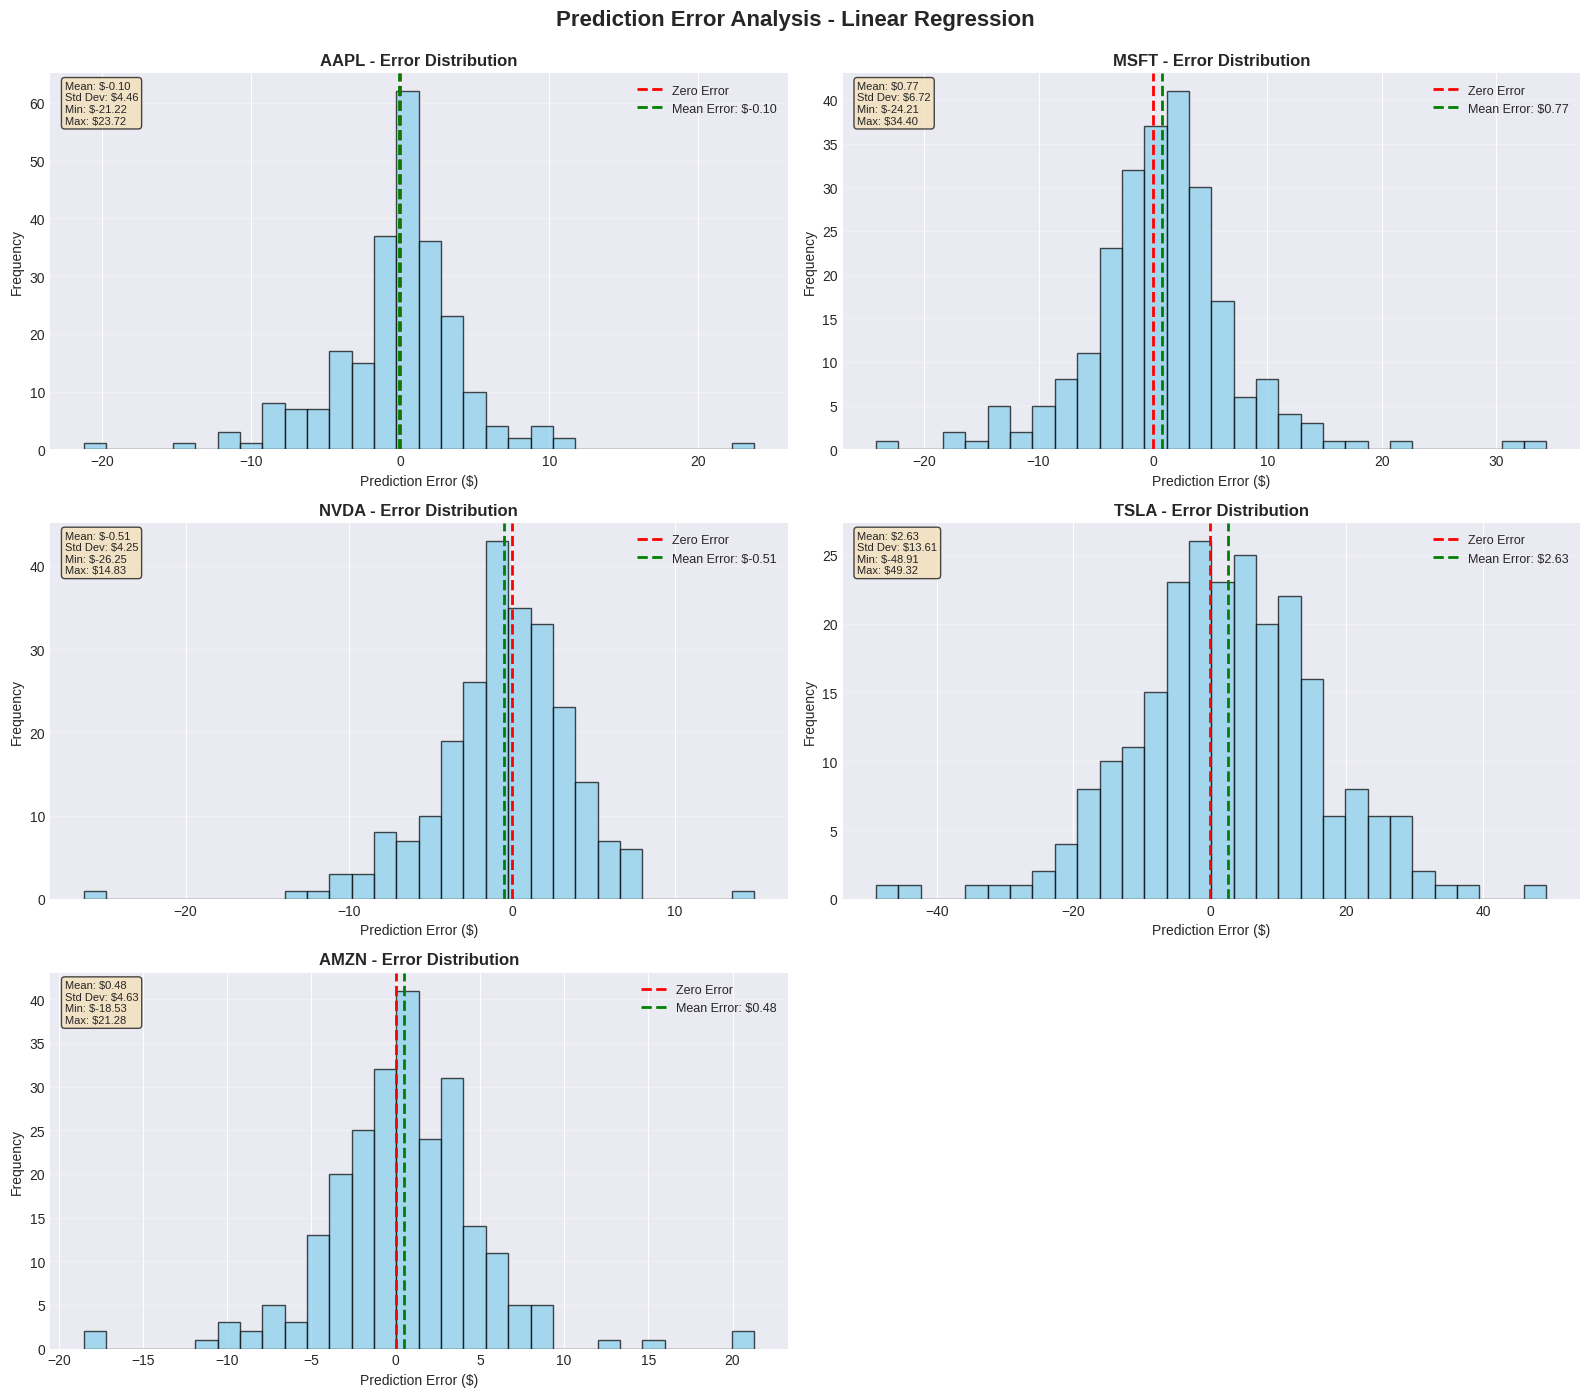


✓ Error distribution analysis complete for Linear Regression


In [58]:
# Prediction Error Distribution and Residual Analysis
fig, axes = plt.subplots(3, 2, figsize=(16, 14))
fig.suptitle(f'Prediction Error Analysis - {best_model}', fontsize=16, fontweight='bold', y=0.995)
axes = axes.flatten()

for idx, ticker in enumerate(tickers):
    if ticker not in best_model_predictions:
        continue

    ax = axes[idx]
    pred_data = best_model_predictions[ticker]

    y_test = pred_data['y_test']
    y_pred = pred_data['y_pred']

    # Calculate prediction errors (residuals)
    errors = y_test - y_pred

    # Create histogram of errors
    ax.hist(errors, bins=30, edgecolor='black', alpha=0.7, color='skyblue')
    ax.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
    ax.axvline(float(errors.mean()), color='green', linestyle='--', linewidth=2,
               label=f'Mean Error: ${float(errors.mean()):.2f}')

    # Add title and labels
    ax.set_title(f'{ticker} - Error Distribution', fontsize=12, fontweight='bold')
    ax.set_xlabel('Prediction Error ($)', fontsize=10)
    ax.set_ylabel('Frequency', fontsize=10)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3, axis='y')

    # Add statistics
    stats_text = (f'Mean: ${float(errors.mean()):.2f}\n'
                  f'Std Dev: ${float(errors.std()):.2f}\n'
                  f'Min: ${float(errors.min()):.2f}\n'
                  f'Max: ${float(errors.max()):.2f}')

    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7),
            fontsize=8)

# Hide extra subplot
axes[-1].axis('off')
plt.tight_layout()
plt.show()

print(f"\n✓ Error distribution analysis complete for {best_model}")

# Discussion & Conclusion

## Key Findings

**Model Performance:**
- Baseline persistence model achieved R² = 0.959, nearly matching Linear Regression (R² = 0.957)
- Complex models (Random Forest, Gradient Boosting, KNN) showed severe overfitting with negative R² scores
- Neural Network performed best among complex models (R² = 0.693) due to regularization
- Results provide empirical support for market efficiency - historical prices are fully incorporated into current prices

**Overfitting Analysis:**
- Tree-based models memorized training noise despite regularization attempts
- 21 features may have introduced more noise than signal for some models
- Feature selection showed that Close_lag_1 (previous day's price) is most predictive
- Simpler models generalized better on this high-efficiency market data

**Stock-Specific Patterns:**
- MSFT: Most predictable (R² = 0.984), stable growth, low volatility
- TSLA: High volatility where Neural Network outperformed tree methods
- Different stocks may benefit from different model architectures

**Limitations:**
- Single 80/20 split (walk-forward validation would be more robust)
- Limited to 5 tech stocks over 5 years
- No external features (fundamentals, sentiment, macroeconomic indicators)
- Transaction costs and slippage not considered

## Conclusion

This project demonstrates that for stock price prediction:
1. **Simple models (Baseline, Linear Regression) outperformed complex ones** - evidence for market efficiency
2. **Feature engineering matters** - technical indicators provided value, but previous price dominated
3. **Regularization is critical** - Neural Network succeeded where other complex models failed
4. **Model selection should be problem-specific** - not all data benefits from complexity

**Practical Recommendation:** Use baseline or linear regression for similar problems. Even with sophisticated ML techniques, beating market efficiency is challenging. Complex models require genuine signal, not just data volume.